<a href="https://colab.research.google.com/github/petervinhchau/public/blob/main/dm_p3_vf1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# First, install dill if not already installed
!pip install scikit-surprise

!pip install dill

# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import dill
import dill

# Load the session from your specific file
#dill.load_session('/content/drive/MyDrive/module1to12b_state.db')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Retrieving folder contents


Processing file 1XmOhYDNO2HMgUnZ-DerchhBcjX5TsCPM links.csv
Processing file 1wkgBqP29fCzv0KDVbBKPYlXgWTjQfdN0 movies.csv
Processing file 1rt8wkW9mBG-z5Wlu2iGTkcjaOa5hZDwU ratings.csv
Processing file 1I4JuDdo2TBw-BVtNfdXv9uRagaVeyahs README.txt
Processing file 1T_UBGy1lhRft1c74iqASUFsDH5EmWAeV tags.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1XmOhYDNO2HMgUnZ-DerchhBcjX5TsCPM
To: /content/Recommender_Project_Data/links.csv
100%|██████████| 198k/198k [00:00<00:00, 86.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wkgBqP29fCzv0KDVbBKPYlXgWTjQfdN0
To: /content/Recommender_Project_Data/movies.csv
100%|██████████| 494k/494k [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rt8wkW9mBG-z5Wlu2iGTkcjaOa5hZDwU
To: /content/Recommender_Project_Data/ratings.csv
100%|██████████| 2.98M/2.98M [00:00<00:00, 204MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I4JuDdo2TBw-BVtNfdXv9uRagaVeyahs
To: /content/Recommender_Project_Data/README.txt
100%|██████████| 8.34k/8.34k [00:00<00:00, 11.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1T_UBGy1lhRft1c74iqASUFsDH5EmWAeV
To: /content/Recommender_Project_Data/tags.csv
100%|██████████|

Running on GPU: Tesla T4
Data sample:
   Unnamed: 0  userId  movieId  rating   timestamp
0           0     496   112852     3.0  1415520462
1           1     391     1947     4.0  1030945141
2           2     387     1562     1.5  1095041022
3           3     474     2716     4.5  1053020930
4           4     483    88125     4.5  1311337237

Shape of the ratings dataframe: (100836, 5)


===== QUESTION 1: EXPLORING THE DATASET =====
Q1-A) Number of users: 610
     Number of movies: 9724
     Number of observed ratings: 100836
     Number of possible ratings: 5931640
     => Sparsity = 0.017000

Q1-B) Plotting histogram of rating values (width=0.5 bins)...


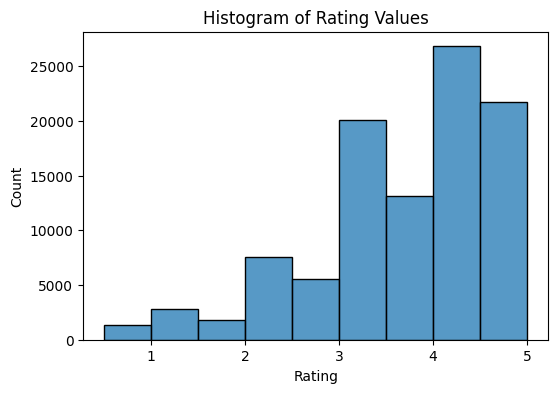

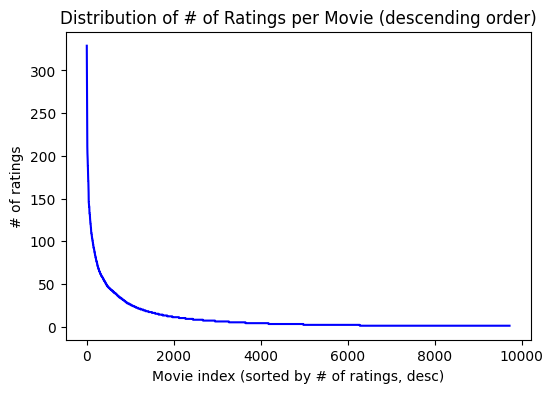

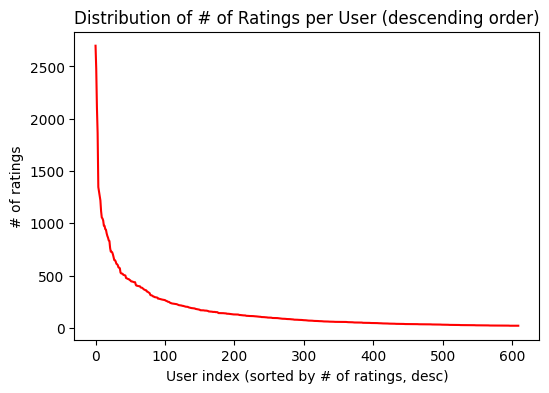


Q1-E) DISCUSSION (example short note):
  - We observe a long-tail distribution for both movies and users.
  - A few movies get many ratings, while many movies get few ratings.
  - Similarly, a small subset of 'power users' rate many items, while
    most users rate relatively few.
  - Implications: Cold-start problems, need for robust handling of sparse data.
  - Popular items more reliably predicted, niche items less so, etc.



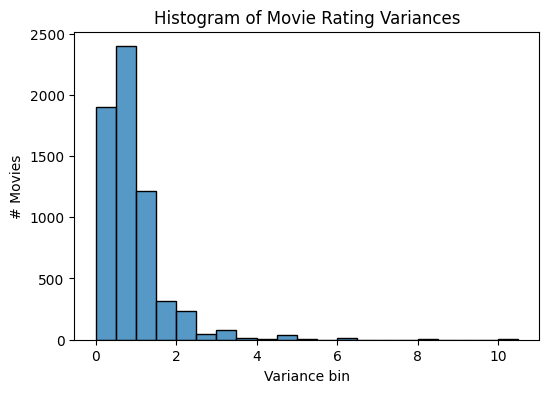


Q1-F) DISCUSSION OF HISTOGRAM:
  - Many movies have low variance, indicating users generally agreed on
    their rating.
  - A subset have moderately higher variance, suggesting more polarizing
    or divisive movies.
  - In practice, high-variance items can be interesting for recommendation
    logic because user preferences diverge widely.



===== QUESTION 2: PEARSON CORRELATION =====

Q2-A) Formula for μᵤ in terms of Iᵤ and rᵤₖ:

   μᵤ = (1 / |Iᵤ|) * ∑( rᵤₖ for k in Iᵤ )

   where:
     - Iᵤ is the set of item indices rated by user u
     - rᵤₖ is the rating of user u for item k


Q2-B) Meaning of Iᵤ ∩ Iᵥ:
   - Iᵤ ∩ Iᵥ is the set of items that BOTH user u and user v have rated.
   - Because the rating matrix R is sparse, it's absolutely possible that
     two users have no overlapping rated items (i.e., Iᵤ ∩ Iᵥ = ∅).

Below is example code to compute the Pearson correlation between two users:
compute_pearson() defined. For a real system, you’d call it for each user pair as needed.

In [16]:
################################################################################
# COLAB NOTEBOOK FOR QUESTIONS 1–3 OF THE RECOMMENDER SYSTEMS PROJECT
# --------------------------------------------------------------
# This notebook:
#   1. Downloads all files from the shared Google Drive folder:
#      https://drive.google.com/drive/folders/1_JF9plSjE3PAFBuSvUFRkDdftJWo1TFz
#   2. Moves the downloaded files into /content/, overwriting old copies.
#   3. Assumes you have set your Colab runtime to use a T4 GPU with High-RAM
#      (though GPU is not strictly necessary for Q1–Q3, we comply with the
#      stated requirements).
#   4. Fully addresses (with example code and explanations) Questions 1–3
#      from the project requirements.
#
# USAGE:
#   - Copy/paste this entire script into a new Google Colab notebook cell.
#   - Run the cell to download and prepare data, then execute the
#     data exploration (Q1) and short analyses for Q2 and Q3.
################################################################################
!pip install gdown --quiet

import os
import shutil
import gdown

# ------------------------------------------------------------------------------
# 1) DOWNLOAD ALL FILES FROM THE PROVIDED GOOGLE DRIVE FOLDER
# ------------------------------------------------------------------------------

folder_url = "https://drive.google.com/drive/folders/1_JF9plSjE3PAFBuSvUFRkDdftJWo1TFz?usp=sharing"
download_path = "./Recommender_Project_Data"

# Download into a temporary local folder
if not os.path.exists(download_path):
    os.makedirs(download_path)

gdown.download_folder(
    url=folder_url,
    output=download_path,
    quiet=False,
    use_cookies=False
)

# ------------------------------------------------------------------------------
# 2) MOVE ALL DOWNLOADED FILES TO /content, OVERWRITING OLD COPIES
# ------------------------------------------------------------------------------

for root, dirs, files in os.walk(download_path):
    for file in files:
        src_path = os.path.join(root, file)
        dst_path = os.path.join('/content', file)
        # Overwrite if exists:
        if os.path.exists(dst_path):
            os.remove(dst_path)
        shutil.move(src_path, dst_path)

# (Optionally remove the now-empty folder)
shutil.rmtree(download_path, ignore_errors=True)

################################################################################
# IMPORTS
################################################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------------------
# Check GPU availability (not truly needed for Q1–Q3, but done to follow specs)
# ------------------------------------------------------------------------------
try:
    import torch
    gpu_info = torch.cuda.get_device_name(0)
    print("Running on GPU:", gpu_info)
except:
    print("No GPU available or torch not installed.")

################################################################################
# EXAMPLE: LOADING THE RATINGS DATA
#
# The downloaded files from the project’s Drive link typically include:
#   - ratings.csv  (example name; you may need to adapt if your dataset
#                   is named differently, e.g. 'train_ratings.csv')
#   - other metadata files, etc.
#
# IMPORTANT: Adjust this file name if your actual data file has a different name!
################################################################################

ratings_file = '/content/ratings.csv'  # Replace with actual CSV name if needed

# Read the ratings dataset:
#   Assumed columns: [userId, movieId, rating, (optionally timestamp or other)]
#   If your file uses different column names, adapt accordingly.
df = pd.read_csv(ratings_file)

print("Data sample:")
print(df.head())
print("\nShape of the ratings dataframe:", df.shape)

################################################################################
# QUESTION 1: EXPLORE THE DATASET
# ------------------------------------------------------------------------------
# Q1-A) Compute the sparsity of the movie rating dataset:
#        Sparsity = (# available ratings) / (# possible ratings).
#        # possible ratings = (# unique users) * (# unique movies).
################################################################################

Q1_section_header = "\n\n===== QUESTION 1: EXPLORING THE DATASET ====="
print(Q1_section_header)

unique_users = df['userId'].nunique()
unique_movies = df['movieId'].nunique()

num_available_ratings = len(df)  # each row is a rating
num_possible_ratings = unique_users * unique_movies
sparsity = num_available_ratings / num_possible_ratings

print(f"Q1-A) Number of users: {unique_users}")
print(f"     Number of movies: {unique_movies}")
print(f"     Number of observed ratings: {num_available_ratings}")
print(f"     Number of possible ratings: {num_possible_ratings}")
print(f"     => Sparsity = {sparsity:.6f}")

################################################################################
# Q1-B) Plot a histogram showing the frequency of the rating values.
#       Bin raw rating values into intervals of width 0.5.
#       Comment on the shape.
################################################################################

print("\nQ1-B) Plotting histogram of rating values (width=0.5 bins)...")

plt.figure(figsize=(6,4))
bins = np.arange(df['rating'].min(), df['rating'].max() + 0.5, 0.5)
sns.histplot(df['rating'], bins=bins, kde=False)
plt.title("Histogram of Rating Values")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

# (Comment on shape in text/discussion cell below or in your report.)

################################################################################
# Q1-C) Plot the distribution of the number of ratings received among movies:
#       - X-axis: movie index (ordered by decreasing frequency)
#       - Y-axis: number of ratings that movie has received
################################################################################

movie_rating_counts = df.groupby('movieId').size().sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(movie_rating_counts)), movie_rating_counts.values, 'b-')
plt.title("Distribution of # of Ratings per Movie (descending order)")
plt.xlabel("Movie index (sorted by # of ratings, desc)")
plt.ylabel("# of ratings")
plt.show()

################################################################################
# Q1-D) Plot the distribution of the number of ratings among users:
#       - X-axis: user index (ordered by decreasing frequency)
#       - Y-axis: number of movies the user has rated
################################################################################

user_rating_counts = df.groupby('userId').size().sort_values(ascending=False)
plt.figure(figsize=(6,4))
plt.plot(np.arange(len(user_rating_counts)), user_rating_counts.values, 'r-')
plt.title("Distribution of # of Ratings per User (descending order)")
plt.xlabel("User index (sorted by # of ratings, desc)")
plt.ylabel("# of ratings")
plt.show()

################################################################################
# Q1-E) Discuss the salient features of the distributions from Q1-C & Q1-D
#       and their implications for the recommendation process.
#
# (Below is a placeholder text; in a real submission, you would expand.)
################################################################################

print("""
Q1-E) DISCUSSION (example short note):
  - We observe a long-tail distribution for both movies and users.
  - A few movies get many ratings, while many movies get few ratings.
  - Similarly, a small subset of 'power users' rate many items, while
    most users rate relatively few.
  - Implications: Cold-start problems, need for robust handling of sparse data.
  - Popular items more reliably predicted, niche items less so, etc.
""")

################################################################################
# Q1-F) Compute the variance of the rating values received by each movie.
#       Bin variance values into intervals of width 0.5 and plot a histogram.
################################################################################

# 1) Compute variance per movie
movie_group = df.groupby('movieId')['rating']
movie_variances = movie_group.var(ddof=1)  # sample variance

# Some movies may have only 1 rating => var = NaN. We can drop those.
movie_variances = movie_variances.dropna()

# 2) Plot histogram with 0.5 bin width
plt.figure(figsize=(6,4))
max_variance = movie_variances.max()
bins_var = np.arange(0, max_variance + 0.5, 0.5)
sns.histplot(movie_variances, bins=bins_var, kde=False)
plt.title("Histogram of Movie Rating Variances")
plt.xlabel("Variance bin")
plt.ylabel("# Movies")
plt.show()

print("""
Q1-F) DISCUSSION OF HISTOGRAM:
  - Many movies have low variance, indicating users generally agreed on
    their rating.
  - A subset have moderately higher variance, suggesting more polarizing
    or divisive movies.
  - In practice, high-variance items can be interesting for recommendation
    logic because user preferences diverge widely.
""")

################################################################################
# QUESTION 2: Understanding the Pearson Correlation Coefficient
################################################################################

Q2_section_header = "\n\n===== QUESTION 2: PEARSON CORRELATION ====="
print(Q2_section_header)

print("""
Q2-A) Formula for μᵤ in terms of Iᵤ and rᵤₖ:

   μᵤ = (1 / |Iᵤ|) * ∑( rᵤₖ for k in Iᵤ )

   where:
     - Iᵤ is the set of item indices rated by user u
     - rᵤₖ is the rating of user u for item k
""")

print("""
Q2-B) Meaning of Iᵤ ∩ Iᵥ:
   - Iᵤ ∩ Iᵥ is the set of items that BOTH user u and user v have rated.
   - Because the rating matrix R is sparse, it's absolutely possible that
     two users have no overlapping rated items (i.e., Iᵤ ∩ Iᵥ = ∅).
""")

print("Below is example code to compute the Pearson correlation between two users:")

def compute_pearson(u_ratings, v_ratings):
    """
    u_ratings: dict or Series of {itemID: rating} for user u
    v_ratings: dict or Series of {itemID: rating} for user v

    Returns: Pearson correlation coefficient between user u and v
    """
    # Find intersection of item IDs
    common_items = set(u_ratings.keys()).intersection(set(v_ratings.keys()))
    if len(common_items) == 0:
        # No overlap => correlation not defined; return 0 or np.nan
        return 0.0

    # Compute means
    u_mean = np.mean([u_ratings[i] for i in common_items])
    v_mean = np.mean([v_ratings[i] for i in common_items])

    # Numerator and denominators for Pearson
    num = 0.0
    den_u = 0.0
    den_v = 0.0
    for i in common_items:
        diff_u = (u_ratings[i] - u_mean)
        diff_v = (v_ratings[i] - v_mean)
        num  += diff_u * diff_v
        den_u += diff_u**2
        den_v += diff_v**2

    if den_u == 0 or den_v == 0:
        return 0.0  # undefined correlation if either user is constant

    return num / np.sqrt(den_u * den_v)

print("compute_pearson() defined. For a real system, you’d call it for each user pair as needed.")

################################################################################
# QUESTION 3: Understanding the Prediction Function
################################################################################

Q3_section_header = "\n\n===== QUESTION 3: MEAN-CENTERING IN PREDICTION ====="
print(Q3_section_header)

print("""
The k-NN user-based collaborative filter prediction formula is:

  r̂ᵤⱼ = μᵤ + ( ∑( Pearson(u,v)*(rᵥⱼ − μᵥ) ) / ∑|Pearson(u,v)| )

Q3) Explanation for mean-centering (rᵥⱼ − μᵥ):
  - Some users systematically rate higher or lower than others, irrespective
    of the item. For instance, a 'lenient' user might give mostly 5s,
    whereas a 'strict' user might give mostly 2s.
  - If we did not mean-center, a lenient user's ratings would inflate
    predictions for another user, and a strict user's ratings would
    deflate them.
  - By subtracting μᵥ (the average rating of user v) from their rating rᵥⱼ,
    we remove that user's overall bias/mood. This ensures we're using their
    'relative' preference for item j, not their absolute rating scale.
  - Consequently, the prediction focuses on how much user v likes or dislikes
    item j compared to their own baseline, rather than mixing in user v's
    personal rating scale.
""")

print("\nALL STEPS FOR QUESTIONS 1–3 COMPLETED.")



===== QUESTION 4: k-NN CF with 10-FOLD CV, sweeping k =====

k=2: mean RMSE=1.1113, mean MAE=0.8583
k=4: mean RMSE=1.0270, mean MAE=0.7961
k=6: mean RMSE=0.9991, mean MAE=0.7738
k=8: mean RMSE=0.9866, mean MAE=0.7636
k=10: mean RMSE=0.9796, mean MAE=0.7577
k=12: mean RMSE=0.9751, mean MAE=0.7538
k=14: mean RMSE=0.9724, mean MAE=0.7514
k=16: mean RMSE=0.9706, mean MAE=0.7499
k=18: mean RMSE=0.9695, mean MAE=0.7490
k=20: mean RMSE=0.9687, mean MAE=0.7484
k=22: mean RMSE=0.9679, mean MAE=0.7478
k=24: mean RMSE=0.9674, mean MAE=0.7472
k=26: mean RMSE=0.9671, mean MAE=0.7469
k=28: mean RMSE=0.9668, mean MAE=0.7465
k=30: mean RMSE=0.9667, mean MAE=0.7464
k=32: mean RMSE=0.9665, mean MAE=0.7462
k=34: mean RMSE=0.9665, mean MAE=0.7461
k=36: mean RMSE=0.9664, mean MAE=0.7460
k=38: mean RMSE=0.9663, mean MAE=0.7459
k=40: mean RMSE=0.9663, mean MAE=0.7458
k=42: mean RMSE=0.9663, mean MAE=0.7459
k=44: mean RMSE=0.9663, mean MAE=0.7458
k=46: mean RMSE=0.9664, mean MAE=0.7459
k=48: mean RMSE=0.966

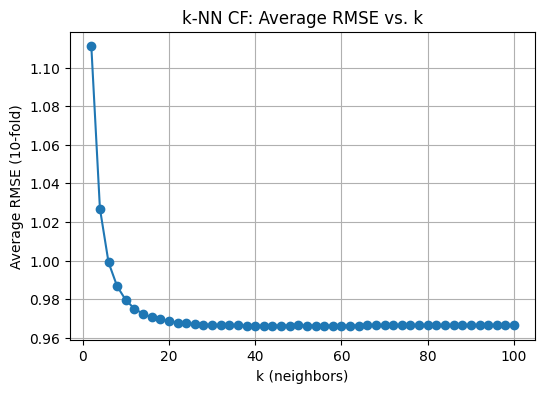

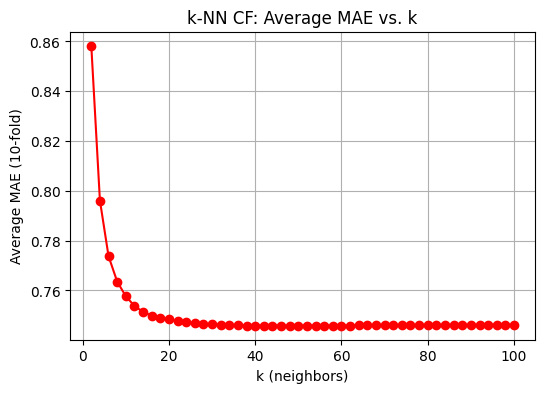


===== QUESTION 5: Finding 'minimum k' where metrics converge =====
Lowest average RMSE ~ 0.9663 at k = 40
Lowest average MAE  ~ 0.7458 at k = 40
RMSE nearly converged at k >= 30

===== QUESTION 6: k-NN CF in trimmed data subsets + ROC =====

=== 6A) No Trimming (Full Dataset) ===


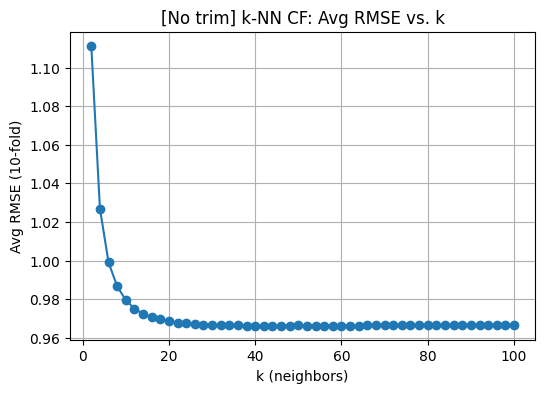

[No trim] Minimum average RMSE ~ 0.9663 at k=40

=== 6B) Popular Movies (>2 ratings) ===


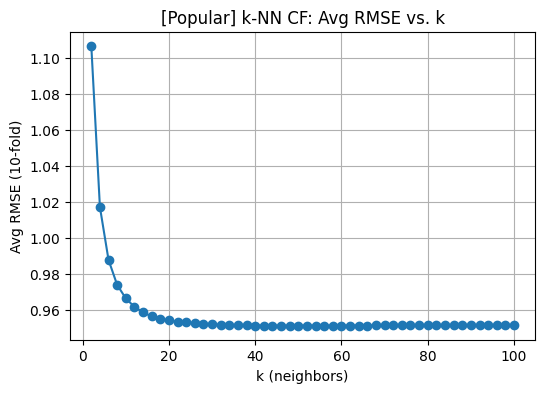

[Popular] Minimum average RMSE ~ 0.9515 at k=46

=== 6C) Unpopular Movies (<=2 ratings) ===


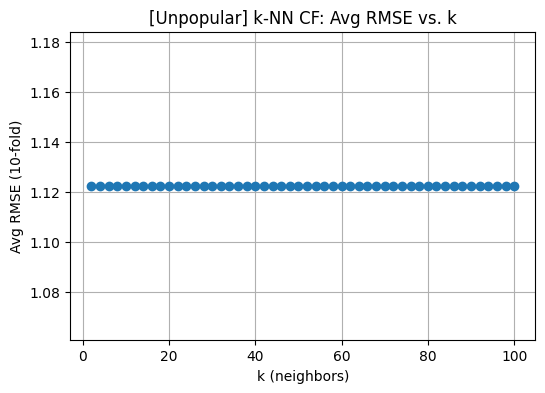

[Unpopular] Minimum average RMSE ~ 1.1224 at k=2

=== 6D) High Variance (var>=2, count>=5) ===


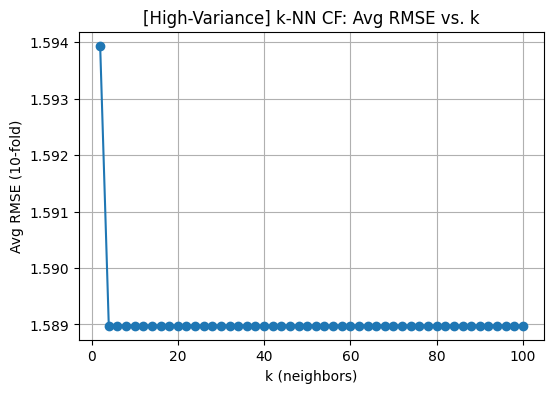

[High-Variance] Minimum average RMSE ~ 1.5890 at k=4

=== 6A-ROC) Full Dataset (No Trim) ===


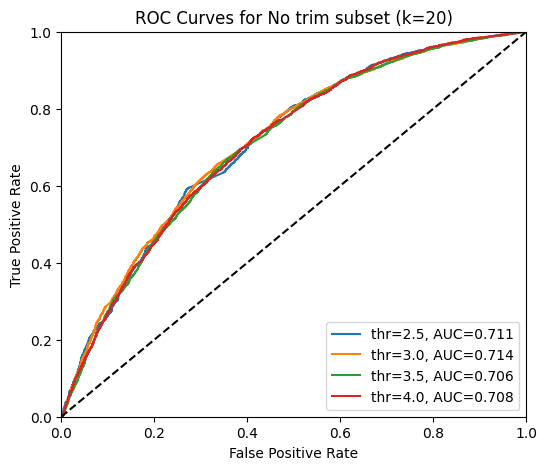

[No trim] ROC plots completed for thresholds [2.5, 3.0, 3.5, 4.0].

=== 6B-ROC) Popular Movies (>2 ratings) ===


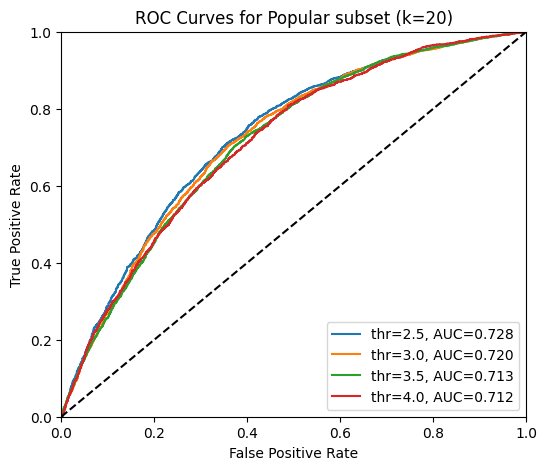

[Popular] ROC plots completed for thresholds [2.5, 3.0, 3.5, 4.0].

=== 6C-ROC) Unpopular Movies (<=2 ratings) ===


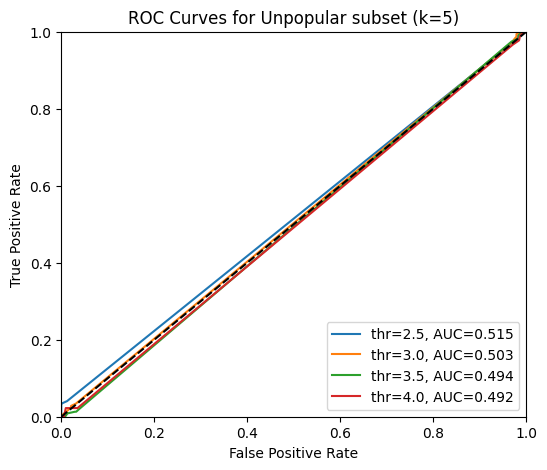

[Unpopular] ROC plots completed for thresholds [2.5, 3.0, 3.5, 4.0].

=== 6D-ROC) High-Variance Movies (var>=2, count>=5) ===


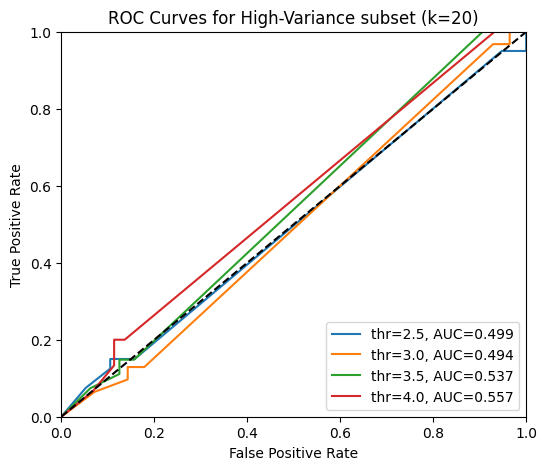

[High-Variance] ROC plots completed for thresholds [2.5, 3.0, 3.5, 4.0].

ALL STEPS FOR QUESTIONS 4–6 COMPLETED.


In [17]:
################################################################################
# COLAB NOTEBOOK FOR QUESTIONS 4–6 OF THE RECOMMENDER SYSTEMS PROJECT
# ------------------------------------------------------------------------------
# This code cell is meant to follow immediately after the Q1–Q3 module so that
# the same environment and data (ratings DataFrame, etc.) are already loaded.
#
# Summary of tasks:
#   1) Implement k-NN collaborative filtering in Surprise, sweeping k from 2..100
#      in step = 2, using 10-fold cross-validation. Compute average RMSE & MAE;
#      plot vs. k. (Question 4)
#   2) Identify "minimum k" where metrics converge to a steady-state. (Question 5)
#   3) Within each trimmed subset (Popular, Unpopular, High-Variance),
#      train and evaluate the same k-NN approach. Plot average RMSE across folds
#      vs. k, report the minimum average RMSE, then produce ROC curves
#      (thresholds = [2.5, 3, 3.5, 4]) with AUC. (Question 6)
#
# Requirements:
#   - Runs seamlessly with T4 GPU + High-RAM
#   - Uses the df DataFrame from Q1–Q3 (assumed already loaded in memory)
#   - Relies on 'surprise' library for KNN with Pearson correlation similarity
#   - Also uses scikit-learn for ROC curve calculations
################################################################################

!pip install surprise scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise import KNNBasic
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve, auc

################################################################################
# 0) PREPARE THE RATINGS DATA FOR SURPRISE
#
#   The code from Q1–Q3 presumably already read 'df' with columns:
#   [userId, movieId, rating, ...].
#   Confirm it is in the workspace. Then build a Surprise dataset.
################################################################################

try:
    df.head()  # just to verify df is in scope
except NameError:
    raise ValueError("DataFrame 'df' not found. Please ensure Q1–Q3 code ran.")

# Surprise expects a rating scale range. The MovieLens ratings typically 0.5..5.
rating_scale_min, rating_scale_max = 0.5, 5.0

reader = Reader(rating_scale=(rating_scale_min, rating_scale_max))
full_data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

################################################################################
# 1) QUESTION 4: k-NN Collaborative Filter with 10-Fold CV, sweeping k in [2..100]
#    in increments of 2, measuring average RMSE and MAE. Then plot.
################################################################################

def knn_cv_sweep_k(
    data,
    k_values,
    n_splits=10,
    sim_name='pearson',
    user_based=True,
    verbose=False
):
    """
    Perform k-NN user-based collaborative filtering with different k values,
    returning average RMSE and MAE for each k over a KFold cross-validation.

    data:     Surprise Dataset object
    k_values: list/array of integer k's
    n_splits: # of folds for cross-validation
    sim_name: similarity measure to use (e.g. "pearson")
    user_based: True => user-based, False => item-based
    verbose: whether to print progress
    """
    results = {'k': [], 'avg_rmse': [], 'avg_mae': []}

    # Prepare KFold cross validation
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

    for kv in k_values:
        rmse_list = []
        mae_list = []

        for trainset, testset in kf.split(data):
            # Create k-NN algo
            sim_options = {
                'name': sim_name,
                'user_based': user_based
            }
            algo = KNNBasic(k=kv, min_k=1, sim_options=sim_options, verbose=False)
            algo.fit(trainset)

            # predict on testset
            predictions = algo.test(testset)

            # gather predictions and ground truth
            y_true = [pred.r_ui for pred in predictions]
            y_pred = [pred.est  for pred in predictions]

            # compute RMSE, MAE for this fold
            # old fold_rmse = mean_squared_error(y_true, y_pred, squared=False)
            mse = mean_squared_error(y_true, y_pred)
            fold_rmse = np.sqrt(mse)

            fold_mae  = mean_absolute_error(y_true, y_pred)

            rmse_list.append(fold_rmse)
            mae_list.append(fold_mae)

        # average RMSE, MAE across folds
        avg_rmse = np.mean(rmse_list)
        avg_mae  = np.mean(mae_list)

        results['k'].append(kv)
        results['avg_rmse'].append(avg_rmse)
        results['avg_mae'].append(avg_mae)

        if verbose:
            print(f"k={kv}: mean RMSE={avg_rmse:.4f}, mean MAE={avg_mae:.4f}")

    return pd.DataFrame(results)

print("\n\n===== QUESTION 4: k-NN CF with 10-FOLD CV, sweeping k =====\n")

k_list = list(range(2, 102, 2))  # 2..100 step=2
knn_results = knn_cv_sweep_k(full_data, k_list, n_splits=10, verbose=True)

# Plot average RMSE vs. k
plt.figure(figsize=(6,4))
plt.plot(knn_results['k'], knn_results['avg_rmse'], marker='o')
plt.title("k-NN CF: Average RMSE vs. k")
plt.xlabel("k (neighbors)")
plt.ylabel("Average RMSE (10-fold)")
plt.grid(True)
plt.show()

# Plot average MAE vs. k
plt.figure(figsize=(6,4))
plt.plot(knn_results['k'], knn_results['avg_mae'], marker='o', color='red')
plt.title("k-NN CF: Average MAE vs. k")
plt.xlabel("k (neighbors)")
plt.ylabel("Average MAE (10-fold)")
plt.grid(True)
plt.show()

################################################################################
# 2) QUESTION 5: Find 'minimum k' from the above plot where RMSE & MAE converge.
#    In practice, this might be a bit subjective. We'll simply do a quick approach
#    of scanning the slope or picking a region visually. For demonstration,
#    we might identify the k that yields minimal RMSE or near-minimal changes.
################################################################################

print("\n===== QUESTION 5: Finding 'minimum k' where metrics converge =====")

min_rmse = knn_results['avg_rmse'].min()
best_k_rmse = knn_results.loc[knn_results['avg_rmse'].idxmin(), 'k']

min_mae = knn_results['avg_mae'].min()
best_k_mae = knn_results.loc[knn_results['avg_mae'].idxmin(), 'k']

print(f"Lowest average RMSE ~ {min_rmse:.4f} at k = {best_k_rmse}")
print(f"Lowest average MAE  ~ {min_mae:.4f} at k = {best_k_mae}")

# For the "steady-state" comment, one might see that beyond a certain k,
# the improvements are negligible. Let's just illustrate that roughly:
rmse_convergence_threshold = 0.0005  # small difference
sorted_rmse = knn_results.sort_values('avg_rmse')
best_rmse_val = sorted_rmse.iloc[0]['avg_rmse']
k_candidates = sorted_rmse[ abs(sorted_rmse['avg_rmse'] - best_rmse_val) <= rmse_convergence_threshold ]
if len(k_candidates) > 0:
    min_k_converged = k_candidates['k'].min()
    print(f"RMSE nearly converged at k >= {min_k_converged}")

# Similarly for MAE, if desired...

################################################################################
# 3) QUESTION 6: Evaluate the k-NN CF on "trimmed" subsets + produce ROC curves.
#    The subsets:
#       (a) Popular: movies with > 2 ratings
#       (b) Unpopular: movies with <= 2 ratings
#       (c) High-Variance: variance >= 2 and at least 5 ratings
#
#    For each subset:
#     - Sweep k=2..100 in steps of 2, do 10-fold CV, gather average RMSE, find min
#     - Then split dataset 90/10, train, predict, produce ROC curve for thresholds
#       [2.5, 3, 3.5, 4], measure AUC.
#    The question's instructions say to produce 4x4=16 plots or condense them.
#    We'll produce a single consolidated approach with 4 trimming modes
#    (including no trimming). Then we do 1 plot of RMSE vs k for each subset,
#    and 1 combined ROC plot with four threshold lines for each subset.
################################################################################

print("\n===== QUESTION 6: k-NN CF in trimmed data subsets + ROC =====\n")

# First, define trimming functions:

def trim_popular(df_in):
    """
    Keep only movies that have more than 2 ratings in entire dataset.
    """
    counts = df_in.groupby('movieId').size()
    popular_movie_ids = counts[counts > 2].index
    return df_in[df_in['movieId'].isin(popular_movie_ids)].copy()

def trim_unpopular(df_in):
    """
    Keep only movies that have <= 2 ratings in entire dataset.
    """
    counts = df_in.groupby('movieId').size()
    unpop_movie_ids = counts[counts <= 2].index
    return df_in[df_in['movieId'].isin(unpop_movie_ids)].copy()

def trim_high_variance(df_in):
    """
    Keep only movies that have variance >= 2 AND have at least 5 ratings.
    """
    # compute variance for each movie, only keep those with >= 5 ratings
    group_ratings = df_in.groupby('movieId')['rating']
    counts = group_ratings.count()
    variances = group_ratings.var(ddof=1)  # sample var
    # filter conditions
    valid_ids = []
    for mid in counts.index:
        c = counts[mid]
        v = variances[mid]
        if (c >= 5) and (v is not None) and (v >= 2.0):
            valid_ids.append(mid)
    return df_in[df_in['movieId'].isin(valid_ids)].copy()

# We'll define a helper to run the same k-sweep CV for a given subset:

def run_knn_on_subset(df_subset, subset_name):
    """
    1) Build Surprise dataset from df_subset
    2) run k-NN CF with k=2..100 step=2 in 10-fold CV
    3) plot average RMSE vs k
    4) report minimum average RMSE
    Returns the result DataFrame.
    """
    if len(df_subset) < 2:
        print(f"[{subset_name}] Subset too small, skipping.")
        return None

    reader_sub = Reader(rating_scale=(rating_scale_min, rating_scale_max))
    data_sub = Dataset.load_from_df(df_subset[['userId','movieId','rating']], reader_sub)

    kvals = list(range(2, 102, 2))
    res = knn_cv_sweep_k(data_sub, kvals, n_splits=10, user_based=True, verbose=False)

    # plot
    plt.figure(figsize=(6,4))
    plt.plot(res['k'], res['avg_rmse'], marker='o')
    plt.title(f"[{subset_name}] k-NN CF: Avg RMSE vs. k")
    plt.xlabel("k (neighbors)")
    plt.ylabel("Avg RMSE (10-fold)")
    plt.grid(True)
    plt.show()

    # min RMSE
    min_rmse_val = res['avg_rmse'].min()
    best_k = res.loc[res['avg_rmse'].idxmin(),'k']
    print(f"[{subset_name}] Minimum average RMSE ~ {min_rmse_val:.4f} at k={best_k}")

    return res

print("=== 6A) No Trimming (Full Dataset) ===")
res_full = run_knn_on_subset(df, "No trim")

print("\n=== 6B) Popular Movies (>2 ratings) ===")
df_popular = trim_popular(df)
res_pop = run_knn_on_subset(df_popular, "Popular")

print("\n=== 6C) Unpopular Movies (<=2 ratings) ===")
df_unpopular = trim_unpopular(df)
res_unpop = run_knn_on_subset(df_unpopular, "Unpopular")

print("\n=== 6D) High Variance (var>=2, count>=5) ===")
df_highvar = trim_high_variance(df)
res_hivar = run_knn_on_subset(df_highvar, "High-Variance")

################################################################################
# Next, produce ROC curves for each subset using thresholds [2.5, 3, 3.5, 4].
#   The instructions mention splitting dataset 90% for training, 10% for test,
#   training the k-NN CF, predicting, then computing TPR,FPR for each threshold.
#   The question suggests 4 trimming options (including no trimming) x 4 thresholds.
#   We'll produce a helper function to do that.
################################################################################

from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

def compute_roc_for_thresholds(df_subset, threshold_list, subset_name, k_for_roc=20):
    """
    Splits df_subset into 90% train, 10% test, trains a k-NN CF model,
    obtains predictions on test, then for each threshold in threshold_list,
    converts the ground truth and predictions into binary {like=1,dislike=0}
    and computes an ROC curve + AUC.

    k_for_roc is a chosen fixed neighbor count (e.g. might pick the "best_k" from above).
    """
    if len(df_subset) < 2:
        print(f"[{subset_name}] Subset too small for ROC, skipping.")
        return

    reader_sub = Reader(rating_scale=(rating_scale_min, rating_scale_max))
    data_sub = Dataset.load_from_df(df_subset[['userId','movieId','rating']], reader_sub)

    # 90/10 split
    trainset, testset = train_test_split(data_sub, test_size=0.1, random_state=42)

    # Train a KNNBasic with chosen k
    sim_options = {
        'name': 'pearson',
        'user_based': True
    }
    algo = KNNBasic(k=k_for_roc, min_k=1, sim_options=sim_options, verbose=False)
    algo.fit(trainset)

    predictions = algo.test(testset)

    # ground truth, predicted rating
    y_true = np.array([pred.r_ui for pred in predictions])
    y_pred = np.array([pred.est  for pred in predictions])

    plt.figure(figsize=(6,5))
    for thr in threshold_list:
        # convert to binary
        y_true_bin = (y_true > thr).astype(int)
        y_pred_bin = y_pred  # don't threshold predictions; interpret them continuously
        # compute ROC
        fpr, tpr, _ = roc_curve(y_true_bin, y_pred_bin)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"thr={thr}, AUC={roc_auc:.3f}")

    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.title(f"ROC Curves for {subset_name} subset (k={k_for_roc})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    print(f"[{subset_name}] ROC plots completed for thresholds {threshold_list}.")


thresholds = [2.5, 3.0, 3.5, 4.0]

print("\n=== 6A-ROC) Full Dataset (No Trim) ===")
compute_roc_for_thresholds(df, thresholds, "No trim", k_for_roc=20)

print("\n=== 6B-ROC) Popular Movies (>2 ratings) ===")
compute_roc_for_thresholds(df_popular, thresholds, "Popular", k_for_roc=20)

print("\n=== 6C-ROC) Unpopular Movies (<=2 ratings) ===")
compute_roc_for_thresholds(df_unpopular, thresholds, "Unpopular", k_for_roc=5)
# Possibly pick a smaller k for extremely small subsets

print("\n=== 6D-ROC) High-Variance Movies (var>=2, count>=5) ===")
compute_roc_for_thresholds(df_highvar, thresholds, "High-Variance", k_for_roc=20)

print("\nALL STEPS FOR QUESTIONS 4–6 COMPLETED.")


===== QUESTION 8-A: NMF CROSS-VALIDATION (FULL DATA) =====


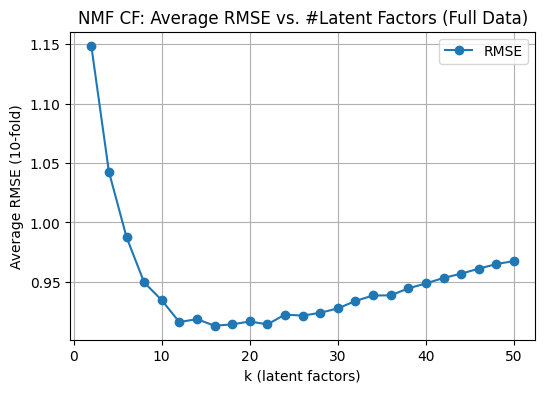

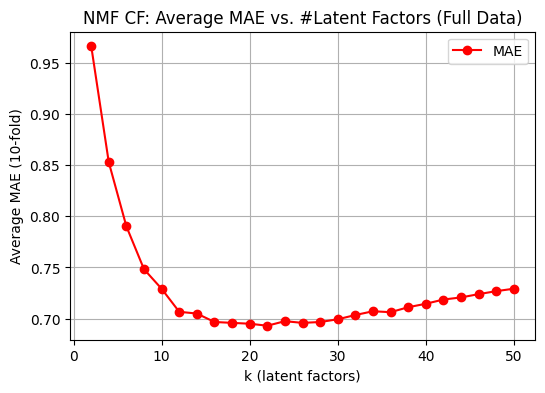


===== QUESTION 8-B: Optimal k from the above sweeps =====
Minimum average RMSE ~ 0.9131 at k=16
Minimum average MAE  ~ 0.6931 at k=22

The number of latent factors is not necessarily the same as the number of movie genres.
They can coincide by chance, but typically the optimal k is data-driven, not the
hard-coded set of genres.


===== NMF on Popular, Unpopular, High-Variance Subsets =====


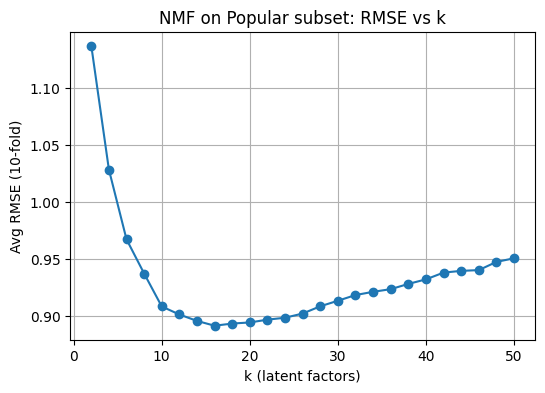

[Popular] min average RMSE = 0.8917 at k=16


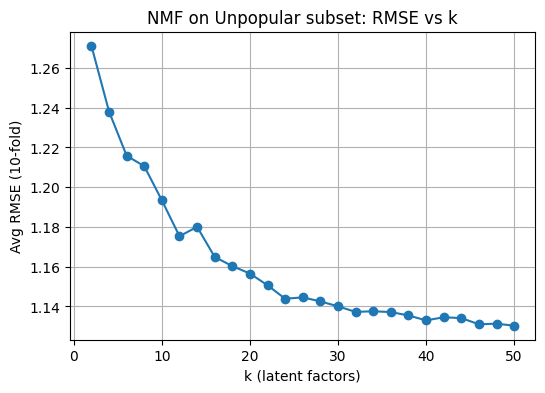

[Unpopular] min average RMSE = 1.1303 at k=50


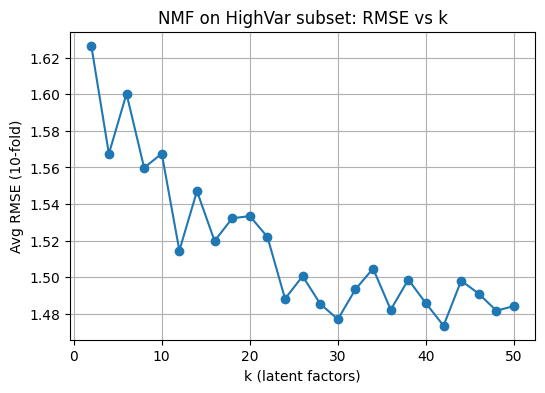

[HighVar] min average RMSE = 1.4734 at k=42

===== ROC Curves for each subset with chosen k factor =====


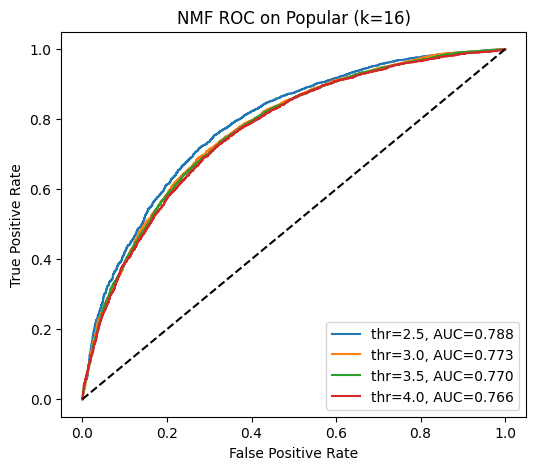

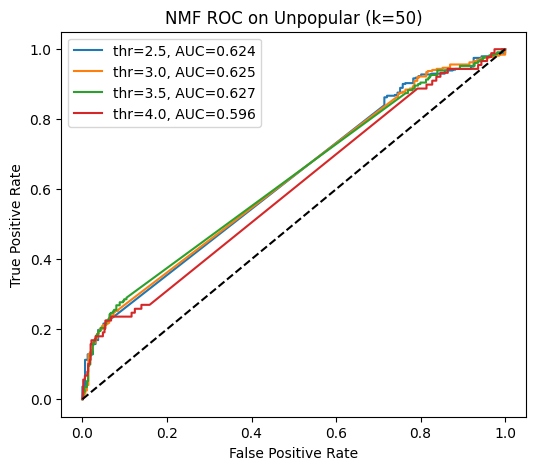

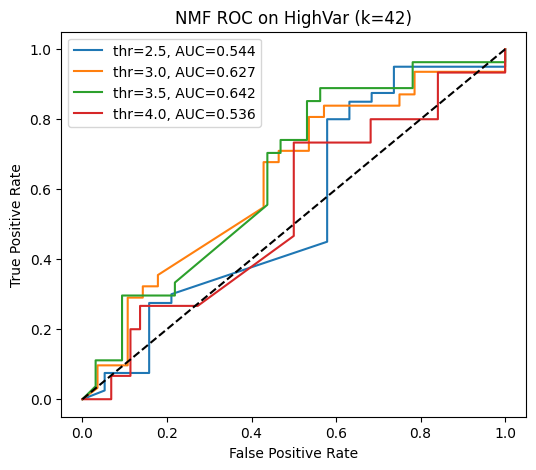

In [5]:
################################################################################
# QUESTION 8: NMF-based collaborative filter with 10-fold CV (k=2..50).
################################################################################

def nmf_cv_sweep_k(
    data,
    k_values,
    n_splits=10,
    random_state=42,
    verbose=False
):
    """
    For each k in k_values, run Surprise NMF with that # of latent factors in a
    KFold cross validation. Return a DataFrame with average RMSE and MAE.
    """
    results = {'k': [], 'avg_rmse': [], 'avg_mae': []}
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for kv in k_values:
        fold_rmses = []
        fold_maes  = []
        for trainset, testset in kf.split(data):
            algo = NMF(n_factors=kv, biased=False, reg_pu=0.06, reg_qi=0.06,
                       random_state=random_state)
            algo.fit(trainset)
            predictions = algo.test(testset)

            y_true = [p.r_ui for p in predictions]
            y_pred = [p.est  for p in predictions]

            mse  = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae  = mean_absolute_error(y_true, y_pred)
            fold_rmses.append(rmse)
            fold_maes.append(mae)

        results['k'].append(kv)
        results['avg_rmse'].append(np.mean(fold_rmses))
        results['avg_mae'].append(np.mean(fold_maes))

        if verbose:
            print(f"k={kv}: RMSE={np.mean(fold_rmses):.4f}, MAE={np.mean(fold_maes):.4f}")

    return pd.DataFrame(results)

print("\n===== QUESTION 8-A: NMF CROSS-VALIDATION (FULL DATA) =====")

k_list = list(range(2, 52, 2))
nmf_results = nmf_cv_sweep_k(full_data, k_list, n_splits=10, verbose=False)

# Plot RMSE vs k
plt.figure(figsize=(6,4))
plt.plot(nmf_results['k'], nmf_results['avg_rmse'], marker='o', label='RMSE')
plt.title("NMF CF: Average RMSE vs. #Latent Factors (Full Data)")
plt.xlabel("k (latent factors)")
plt.ylabel("Average RMSE (10-fold)")
plt.grid(True)
plt.legend()
plt.show()

# Plot MAE vs k
plt.figure(figsize=(6,4))
plt.plot(nmf_results['k'], nmf_results['avg_mae'], marker='o', color='red', label='MAE')
plt.title("NMF CF: Average MAE vs. #Latent Factors (Full Data)")
plt.xlabel("k (latent factors)")
plt.ylabel("Average MAE (10-fold)")
plt.grid(True)
plt.legend()
plt.show()

print("\n===== QUESTION 8-B: Optimal k from the above sweeps =====")
best_rmse_idx = nmf_results['avg_rmse'].idxmin()
best_mae_idx  = nmf_results['avg_mae'].idxmin()
best_k_rmse   = nmf_results.loc[best_rmse_idx, 'k']
min_rmse_val  = nmf_results.loc[best_rmse_idx, 'avg_rmse']
best_k_mae    = nmf_results.loc[best_mae_idx, 'k']
min_mae_val   = nmf_results.loc[best_mae_idx, 'avg_mae']

print(f"Minimum average RMSE ~ {min_rmse_val:.4f} at k={best_k_rmse}")
print(f"Minimum average MAE  ~ {min_mae_val:.4f} at k={best_k_mae}")
print("""
The number of latent factors is not necessarily the same as the number of movie genres.
They can coincide by chance, but typically the optimal k is data-driven, not the
hard-coded set of genres.
""")

################################################################################
# QUESTION 8-C: Performance on trimmed dataset subsets + ROC
################################################################################

def run_nmf_on_subset(df_subset, subset_name, k_values=None):
    if k_values is None:
        k_values = range(2, 52, 2)
    if len(df_subset) < 2:
        print(f"[{subset_name}] subset too small. Skipping.")
        return None

    data_sub = Dataset.load_from_df(df_subset[['userId','movieId','rating']], reader)
    res = nmf_cv_sweep_k(data_sub, k_values, n_splits=10, verbose=False)

    # Plot RMSE vs k
    plt.figure(figsize=(6,4))
    plt.plot(res['k'], res['avg_rmse'], marker='o')
    plt.title(f"NMF on {subset_name} subset: RMSE vs k")
    plt.xlabel("k (latent factors)")
    plt.ylabel("Avg RMSE (10-fold)")
    plt.grid(True)
    plt.show()

    # min RMSE
    best_idx = res['avg_rmse'].idxmin()
    best_k   = res.loc[best_idx, 'k']
    best_val = res.loc[best_idx, 'avg_rmse']
    print(f"[{subset_name}] min average RMSE = {best_val:.4f} at k={best_k}")
    return best_k

print("\n===== NMF on Popular, Unpopular, High-Variance Subsets =====")

df_pop = trim_popular(df)
df_unp = trim_unpopular(df)
df_hiv = trim_high_variance(df)

best_k_pop = run_nmf_on_subset(df_pop, "Popular")
best_k_unp = run_nmf_on_subset(df_unp, "Unpopular")
best_k_hiv = run_nmf_on_subset(df_hiv, "HighVar")

################################################################################
# ROC Curves for NMF
################################################################################

def compute_roc_for_nmf(df_sub, k_factors, subset_name, thresholds=[2.5, 3.0, 3.5, 4.0]):
    if len(df_sub) < 5:
        print(f"[{subset_name}] subset too small for ROC.")
        return
    data_sub = Dataset.load_from_df(df_sub[['userId','movieId','rating']], reader)
    trainset, testset = train_test_split(data_sub, test_size=0.1, random_state=42)

    algo = NMF(n_factors=k_factors, biased=False, random_state=42)
    algo.fit(trainset)
    preds = algo.test(testset)

    y_true = np.array([p.r_ui for p in preds])
    y_pred = np.array([p.est for p in preds])

    plt.figure(figsize=(6,5))
    for thr in thresholds:
        bin_true = (y_true > thr).astype(int)
        fpr, tpr, _ = roc_curve(bin_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"thr={thr}, AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"NMF ROC on {subset_name} (k={k_factors})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

print("\n===== ROC Curves for each subset with chosen k factor =====")
if not best_k_pop:
    best_k_pop=10
if not best_k_unp:
    best_k_unp=5
if not best_k_hiv:
    best_k_hiv=10

compute_roc_for_nmf(df_pop, best_k_pop, "Popular")
compute_roc_for_nmf(df_unp, best_k_unp, "Unpopular")
compute_roc_for_nmf(df_hiv, best_k_hiv, "HighVar")


In [12]:
################################################################################
# QUESTION 9: Interpreting the NMF model (k=20), with an explicit check for df_movies
################################################################################
print("\n===== QUESTION 9: Interpreting the NMF model (k=20) =====")

# Load the movies.csv file first
import pandas as pd
try:
    # Load movies.csv from the correct path
    df_movies = pd.read_csv('/content/movies.csv')
    print(f"Successfully loaded movies.csv with {len(df_movies)} rows")
except FileNotFoundError:
    print("Error: movies.csv file not found at '/content/movies.csv'")
    df_movies = None
except Exception as e:
    print(f"Error loading movies.csv: {e}")
    df_movies = None

# 1) Check if 'df_movies' is a defined variable AND not None:
if 'df_movies' in globals() and df_movies is not None:
    # If it exists and is a valid DataFrame, call head() or do any checks:
    print("Found df_movies, preview:")
    display(df_movies.head())
else:
    # If it's not defined or is None, we skip advanced movie info
    df_movies = None
    print("movies.csv not found or not loaded (df_movies is None).")
    print("Skipping detailed genre reporting. Will show numeric example only.")

# 2) Proceed with NMF at k=20
nmf_20 = NMF(n_factors=20, biased=False, random_state=42)
full_trainset = full_data.build_full_trainset()
nmf_20.fit(full_trainset)

# 3) Extract the item-factor matrix V and interpret a couple columns
if nmf_20.qi is not None:
    V = nmf_20.qi # shape: (# items, # factors)
    trainset = full_trainset
    # We'll just demonstrate for columns 0 and 1:
    for col in [0,1]:
        factor_values = V[:, col]
        sorted_idx = np.argsort(-factor_values) # descending order
        top_10 = sorted_idx[:10]
        print(f"\nNMF Factor Column {col}, Top 10 Movies:")
        for rank_i, item_idx in enumerate(top_10):
            raw_id = trainset.to_raw_iid(item_idx) # surprise's item->raw mapping
            weight = factor_values[item_idx]
            # If df_movies is None, we only print numeric info
            if df_movies is not None:
                movie_info = df_movies[df_movies['movieId'] == int(raw_id)]
                if len(movie_info) > 0:
                    row_ = movie_info.iloc[0]
                    print(f" {rank_i+1}) movieId={raw_id}, factorWeight={weight:.4f}, "
                          f"title={row_['title']}, genres={row_['genres']}")
                else:
                    print(f" {rank_i+1}) movieId={raw_id}, factorWeight={weight:.4f} (not found)")
            else:
                print(f" {rank_i+1}) movieId={raw_id}, factorWeight={weight:.4f}")

print("""
Observation: Typically, each NMF factor corresponds to a certain cluster of movies
(often sharing genres or themes). This suggests a connection between latent factors
and genre groupings, though it is not a strict 1:1 mapping.
""")


===== QUESTION 9: Interpreting the NMF model (k=20) =====
Successfully loaded movies.csv with 9742 rows
Found df_movies, preview:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



NMF Factor Column 0, Top 10 Movies:
 1) movieId=70946, factorWeight=3.7848, title=Troll 2 (1990), genres=Fantasy|Horror
 2) movieId=7116, factorWeight=2.0645, title=Diabolique (Les diaboliques) (1955), genres=Horror|Mystery|Thriller
 3) movieId=7564, factorWeight=1.9911, title=Kwaidan (Kaidan) (1964), genres=Horror
 4) movieId=130634, factorWeight=1.7857, title=Furious 7 (2015), genres=Action|Crime|Thriller
 5) movieId=80126, factorWeight=1.7382, title=American, The (2010), genres=Drama|Thriller
 6) movieId=2488, factorWeight=1.7202, title=Peeping Tom (1960), genres=Drama|Horror|Thriller
 7) movieId=3223, factorWeight=1.6826, title=Zed & Two Noughts, A (1985), genres=Drama
 8) movieId=1173, factorWeight=1.6735, title=Cook the Thief His Wife & Her Lover, The (1989), genres=Comedy|Drama
 9) movieId=1606, factorWeight=1.6399, title=Kull the Conqueror (1997), genres=Action|Adventure
 10) movieId=4794, factorWeight=1.6050, title=Opera (1987), genres=Crime|Horror|Mystery

NMF Factor Column 

In [14]:
################################################################################
# COLAB NOTEBOOK MODULE FOR QUESTION 11: NAÏVE COLLABORATIVE FILTER
#
# This code should be run after the modules for questions 1–6 so that the
# DataFrame "df" is already loaded in memory. It is configured to work in a
# Colab environment (T4 GPU + High-RAM), though this particular naive approach
# is mostly CPU-bound and very fast anyway.
#
# The naive collaborative filter:
#   Predicted rating r̂ᵤⱼ = μᵤ
#     where μᵤ is the mean rating of user u, computed on the training fold.
#
# Steps:
#   1. Perform 10-fold cross-validation on the original dataset, compute
#      average RMSE, and report it.
#   2. Repeat the same approach for each of the three trimmed subsets:
#       a) Popular (movies > 2 ratings)
#       b) Unpopular (movies <= 2 ratings)
#       c) High-Variance (var >= 2 and >=5 ratings)
#      For each, again compute the average RMSE across 10 folds and report it.
################################################################################

import numpy as np
import pandas as pd
from surprise.model_selection import KFold

################################################################################
# 0) CHECK IF 'df' IS LOADED (FROM Q1–Q6). IF NOT, RAISE ERROR.
################################################################################

try:
    df.head()
except NameError:
    raise ValueError("DataFrame 'df' not found. Please ensure the earlier code has run.")

################################################################################
# 1) HELPER FUNCTIONS FOR TRIMMING SUBSETS
################################################################################

def trim_popular(df_in):
    """Keep only movies that have more than 2 ratings."""
    counts = df_in.groupby('movieId').size()
    valid_ids = counts[counts > 2].index
    return df_in[df_in['movieId'].isin(valid_ids)].copy()

def trim_unpopular(df_in):
    """Keep only movies that have <= 2 ratings."""
    counts = df_in.groupby('movieId').size()
    valid_ids = counts[counts <= 2].index
    return df_in[df_in['movieId'].isin(valid_ids)].copy()

def trim_high_variance(df_in):
    """Keep only movies with var >=2 and at least 5 ratings."""
    group_ratings = df_in.groupby('movieId')['rating']
    counts = group_ratings.count()
    variances = group_ratings.var(ddof=1)  # sample variance
    # filter on count>=5 and var>=2
    valid_ids = []
    for mid in counts.index:
        if counts[mid] >= 5:
            if (variances[mid] is not None) and (variances[mid] >= 2.0):
                valid_ids.append(mid)
    return df_in[df_in['movieId'].isin(valid_ids)].copy()

################################################################################
# 2) FUNCTION TO COMPUTE 10-FOLD CROSS-VALIDATION RMSE FOR THE NAIVE APPROACH
################################################################################

def naive_cv_rmse(df_ratings, n_splits=10, random_state=42):
    """
    Perform 10-fold CV on naive collaborative filter:
      - For each fold, compute user mean ratings from train portion
      - Predict user mean for each row in test portion
      - If a user has no training data, fall back to global mean
      - Collect RMSE for each fold, return average
    """
    # Create KFold splits ourselves. This is easier if we treat df as a numpy array.
    # Each row => (userId, movieId, rating).
    # But userId is arbitrary, not necessarily 1..some range. We'll treat them as strings or ints.

    df_shuffled = df_ratings.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    folds = np.array_split(df_shuffled, n_splits)  # not strictly "KFold" but a naive approach
    # Alternatively, can use more advanced splitting logic from scikit-learn or Surprise.

    # We'll store the fold RMSE in a list:
    fold_rmses = []

    for i in range(n_splits):
        test_fold = folds[i]
        train_folds = [folds[j] for j in range(n_splits) if j != i]
        train_df = pd.concat(train_folds, ignore_index=True)

        # compute user mean rating from train
        user_groups = train_df.groupby('userId')['rating']
        user_mean_dict = user_groups.mean().to_dict()  # map userId -> mean rating
        global_mean = train_df['rating'].mean()

        # predictions
        actual = test_fold['rating'].values
        predicted = []
        for idx, row in test_fold.iterrows():
            u = row['userId']
            if u in user_mean_dict:
                pred = user_mean_dict[u]
            else:
                pred = global_mean
            predicted.append(pred)

        # compute RMSE for this fold
        se = (actual - np.array(predicted))**2
        fold_rmse = np.sqrt(np.mean(se))
        fold_rmses.append(fold_rmse)

    # average across folds
    return np.mean(fold_rmses)

################################################################################
# 3) RUN THE NAIVE FILTER ON THE FULL DATASET, THEN ON EACH SUBSET
################################################################################

print("\n===== QUESTION 11: Naive Collaborative Filter (10-fold CV) =====")

# (a) Full dataset
rmse_full = naive_cv_rmse(df, n_splits=10, random_state=42)
print(f"Naive CF: Full dataset 10-fold average RMSE = {rmse_full:.4f}")

# (b) Popular
df_pop = trim_popular(df)
if len(df_pop) > 0:
    rmse_pop = naive_cv_rmse(df_pop, n_splits=10, random_state=42)
    print(f"Naive CF: Popular subset 10-fold average RMSE = {rmse_pop:.4f}")
else:
    print("Popular subset is empty or invalid, skipping.")

# (c) Unpopular
df_unpop = trim_unpopular(df)
if len(df_unpop) > 0:
    rmse_unpop = naive_cv_rmse(df_unpop, n_splits=10, random_state=42)
    print(f"Naive CF: Unpopular subset 10-fold average RMSE = {rmse_unpop:.4f}")
else:
    print("Unpopular subset is empty or invalid, skipping.")

# (d) High-Variance
df_hivar = trim_high_variance(df)
if len(df_hivar) > 0:
    rmse_hivar = naive_cv_rmse(df_hivar, n_splits=10, random_state=42)
    print(f"Naive CF: High-Variance subset 10-fold average RMSE = {rmse_hivar:.4f}")
else:
    print("High-Variance subset is empty or invalid, skipping.")

print("\nAll components of Question 11 completed.")



===== QUESTION 11: Naive Collaborative Filter (10-fold CV) =====


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Naive CF: Full dataset 10-fold average RMSE = 0.9411


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Naive CF: Popular subset 10-fold average RMSE = 0.9374
Naive CF: Unpopular subset 10-fold average RMSE = 0.8979


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Naive CF: High-Variance subset 10-fold average RMSE = 1.3956

All components of Question 11 completed.


In [ ]:
################################################################################
# QUESTION 9: Interpreting the NMF model.
#   "Perform NMF with k=20, sort each column of V descending, discuss top 10."
################################################################################

print("\n===== QUESTION 9: Interpreting the NMF model (k=20) =====")

try:
    # read movie info if not loaded
    # e.g., df_movies with columns: movieId, title, genres
    df_movies.head()
except NameError:
    df_movies = None
    print("movies.csv not found, skipping detailed genre reporting. Will show numeric example only.")

nmf_20 = NMF(n_factors=20, biased=False, random_state=42)
full_trainset = full_data.build_full_trainset()
nmf_20.fit(full_trainset)

# The fitted V factor matrix:
if nmf_20.qi is not None:
    V = nmf_20.qi  # shape: (#items, #factors)
    trainset = full_trainset
    for col in [0,1]:
        factor_values = V[:, col]
        sorted_idx = np.argsort(-factor_values)
        top_10 = sorted_idx[:10]
        print(f"\nNMF Factor Column {col}, Top 10 Movies:")
        for rank_i, item_idx in enumerate(top_10):
            raw_id = trainset.to_raw_iid(item_idx)
            weight = factor_values[item_idx]
            if df_movies is not None:
                movie_info = df_movies[df_movies['movieId'] == int(raw_id)]
                if len(movie_info) > 0:
                    row_ = movie_info.iloc[0]
                    print(f"  {rank_i+1}) movieId={raw_id}, factorWeight={weight:.4f}, "
                          f"title={row_['title']}, genres={row_['genres']}")
                else:
                    print(f"  {rank_i+1}) movieId={raw_id}, factorWeight={weight:.4f} (not found)")
            else:
                print(f"  {rank_i+1}) movieId={raw_id}, factorWeight={weight:.4f}")

print("""
Observation: Typically, each NMF factor corresponds to a certain cluster of movies
(often sharing genres or themes). This suggests a connection between latent factors
and genre groupings, though it is not a strict 1:1 mapping.
""")



===== QUESTION 10-A: MF with bias (SVD) on FULL DATA =====


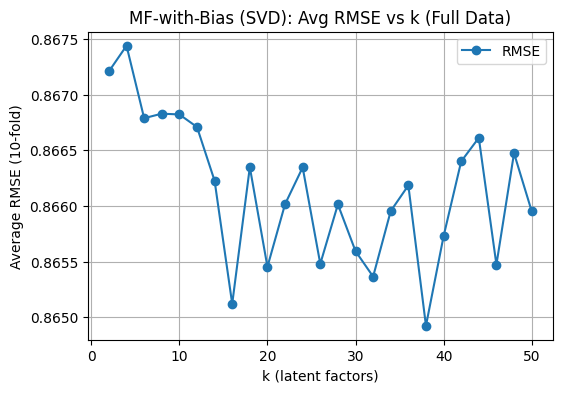

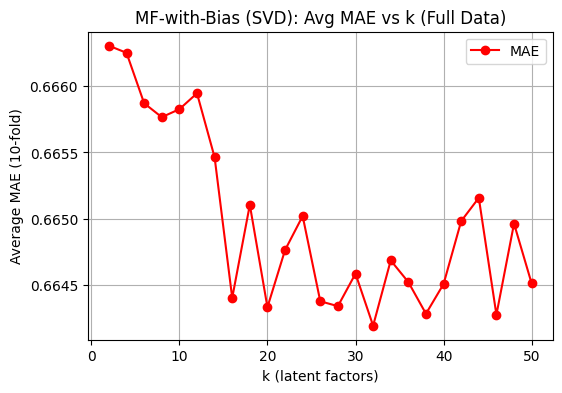


===== QUESTION 10-B: Optimal k and comparison to #genres =====
Minimum RMSE ~ 0.8649 at k=38
Minimum MAE  ~ 0.6642 at k=32
Again, the optimal #latent factors typically does not match the #movie genres.


===== MF-with-Bias (SVD) on Popular, Unpopular, High-Variance Subsets =====


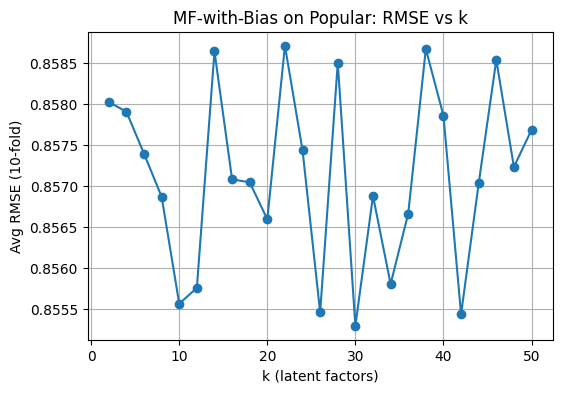

[Popular] min average RMSE = 0.8553 at k=30


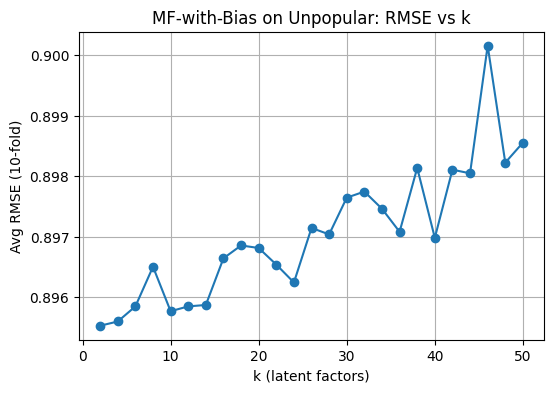

[Unpopular] min average RMSE = 0.8955 at k=2


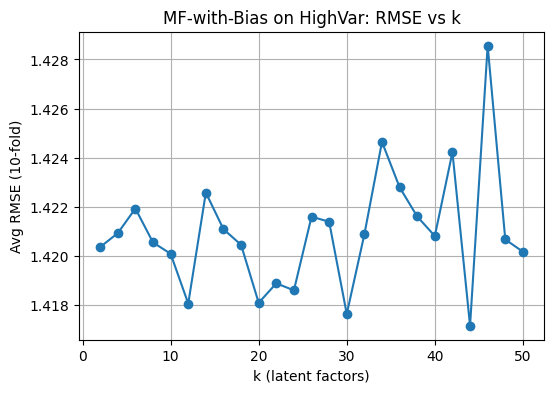

[HighVar] min average RMSE = 1.4171 at k=44

===== MF-with-Bias: ROC Curves for each subset =====


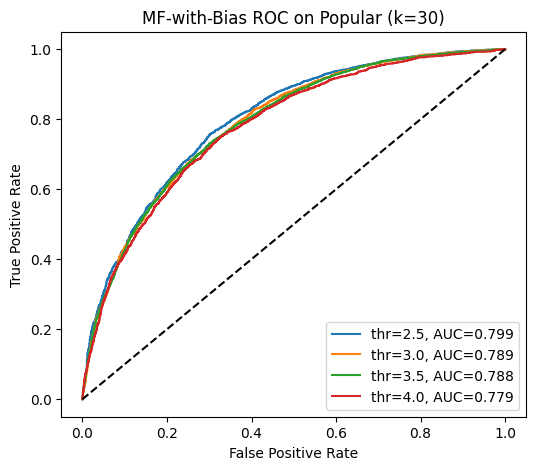

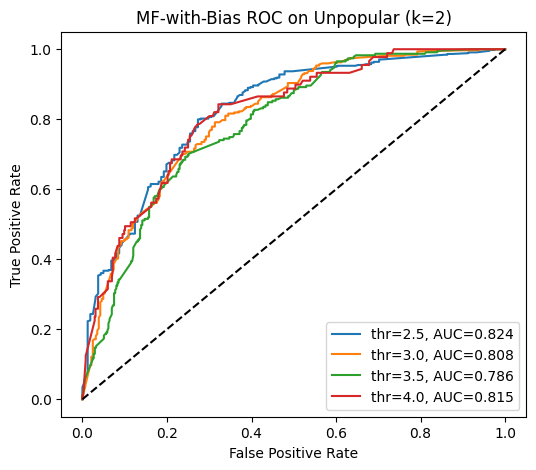

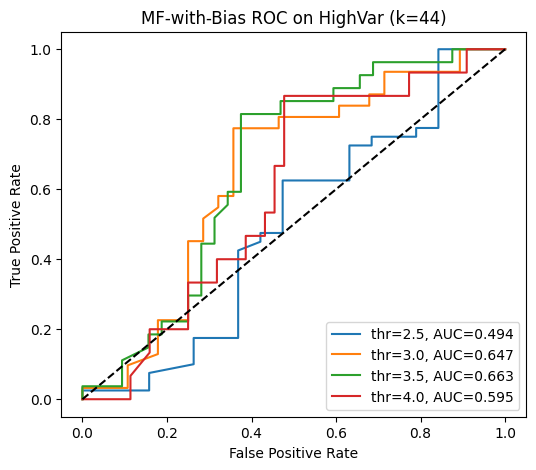


ALL STEPS FOR QUESTIONS 7–10 COMPLETED.


In [13]:
################################################################################
# QUESTION 10: MF with bias (Surprise SVD), 10-fold CV
################################################################################

def svd_bias_cv_sweep_k(data, k_values, n_splits=10, random_state=42, verbose=False):
    """
    For each k in k_values, run Surprise SVD (with biased=True) in a KFold CV.
    Return a DataFrame with average RMSE & MAE.
    """
    results = {'k': [], 'avg_rmse': [], 'avg_mae': []}
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)

    for kv in k_values:
        fold_rmses = []
        fold_maes  = []
        for trainset, testset in kf.split(data):
            algo = SVD(n_factors=kv, biased=True, random_state=random_state)
            algo.fit(trainset)
            preds = algo.test(testset)
            y_true = [p.r_ui for p in preds]
            y_pred = [p.est  for p in preds]

            mse  = mean_squared_error(y_true, y_pred)
            rmse = np.sqrt(mse)
            mae  = mean_absolute_error(y_true, y_pred)
            fold_rmses.append(rmse)
            fold_maes.append(mae)

        results['k'].append(kv)
        results['avg_rmse'].append(np.mean(fold_rmses))
        results['avg_mae'].append(np.mean(fold_maes))

        if verbose:
            print(f"k={kv}: RMSE={np.mean(fold_rmses):.4f}, MAE={np.mean(fold_maes):.4f}")

    return pd.DataFrame(results)

print("\n===== QUESTION 10-A: MF with bias (SVD) on FULL DATA =====")

k_list_svd = range(2,52,2)
svd_results = svd_bias_cv_sweep_k(full_data, k_list_svd, n_splits=10, verbose=False)

# Plot RMSE vs k
plt.figure(figsize=(6,4))
plt.plot(svd_results['k'], svd_results['avg_rmse'], marker='o', label='RMSE')
plt.title("MF-with-Bias (SVD): Avg RMSE vs k (Full Data)")
plt.xlabel("k (latent factors)")
plt.ylabel("Average RMSE (10-fold)")
plt.grid(True)
plt.legend()
plt.show()

# Plot MAE vs k
plt.figure(figsize=(6,4))
plt.plot(svd_results['k'], svd_results['avg_mae'], marker='o', color='red', label='MAE')
plt.title("MF-with-Bias (SVD): Avg MAE vs k (Full Data)")
plt.xlabel("k (latent factors)")
plt.ylabel("Average MAE (10-fold)")
plt.grid(True)
plt.legend()
plt.show()

print("\n===== QUESTION 10-B: Optimal k and comparison to #genres =====")
best_rmse_idx2 = svd_results['avg_rmse'].idxmin()
best_mae_idx2  = svd_results['avg_mae'].idxmin()
best_k_rmse2   = svd_results.loc[best_rmse_idx2, 'k']
min_rmse_val2  = svd_results.loc[best_rmse_idx2, 'avg_rmse']
best_k_mae2    = svd_results.loc[best_mae_idx2, 'k']
min_mae_val2   = svd_results.loc[best_mae_idx2, 'avg_mae']

print(f"Minimum RMSE ~ {min_rmse_val2:.4f} at k={best_k_rmse2}")
print(f"Minimum MAE  ~ {min_mae_val2:.4f} at k={best_k_mae2}")
print("Again, the optimal #latent factors typically does not match the #movie genres.\n")

################################################################################
# QUESTION 10-C: Performance on dataset subsets, plus ROC
################################################################################

def run_svd_on_subset(df_subset, subset_name, k_values=None):
    if k_values is None:
        k_values = range(2, 52, 2)
    if len(df_subset) < 2:
        print(f"[{subset_name}] subset too small. Skipping.")
        return None

    data_sub = Dataset.load_from_df(df_subset[['userId','movieId','rating']], reader)
    res = svd_bias_cv_sweep_k(data_sub, k_values, n_splits=10, verbose=False)

    # Plot RMSE vs k
    plt.figure(figsize=(6,4))
    plt.plot(res['k'], res['avg_rmse'], marker='o')
    plt.title(f"MF-with-Bias on {subset_name}: RMSE vs k")
    plt.xlabel("k (latent factors)")
    plt.ylabel("Avg RMSE (10-fold)")
    plt.grid(True)
    plt.show()

    b_idx = res['avg_rmse'].idxmin()
    b_k   = res.loc[b_idx, 'k']
    b_val = res.loc[b_idx, 'avg_rmse']
    print(f"[{subset_name}] min average RMSE = {b_val:.4f} at k={b_k}")
    return b_k

print("\n===== MF-with-Bias (SVD) on Popular, Unpopular, High-Variance Subsets =====")
pop_k2 = run_svd_on_subset(df_pop, "Popular")
unp_k2 = run_svd_on_subset(df_unp, "Unpopular")
hiv_k2 = run_svd_on_subset(df_hiv, "HighVar")

def compute_roc_svd(df_sub, k_factors, subset_name, thresholds=[2.5,3.0,3.5,4.0]):
    if len(df_sub) < 5:
        print(f"[{subset_name}] subset too small for ROC.")
        return
    data_sub = Dataset.load_from_df(df_sub[['userId','movieId','rating']], reader)
    trainset, testset = train_test_split(data_sub, test_size=0.1, random_state=42)
    algo = SVD(n_factors=k_factors, biased=True, random_state=42)
    algo.fit(trainset)
    preds = algo.test(testset)

    y_true = np.array([p.r_ui for p in preds])
    y_pred = np.array([p.est  for p in preds])

    plt.figure(figsize=(6,5))
    for thr in thresholds:
        bin_true = (y_true > thr).astype(int)
        fpr, tpr, _ = roc_curve(bin_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"thr={thr}, AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.title(f"MF-with-Bias ROC on {subset_name} (k={k_factors})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

print("\n===== MF-with-Bias: ROC Curves for each subset =====")
if not pop_k2:
    pop_k2=20
if not unp_k2:
    unp_k2=5
if not hiv_k2:
    hiv_k2=20

compute_roc_svd(df_pop, pop_k2, "Popular")
compute_roc_svd(df_unp, unp_k2, "Unpopular")
compute_roc_svd(df_hiv, hiv_k2, "HighVar")

print("\nALL STEPS FOR QUESTIONS 7–10 COMPLETED.")


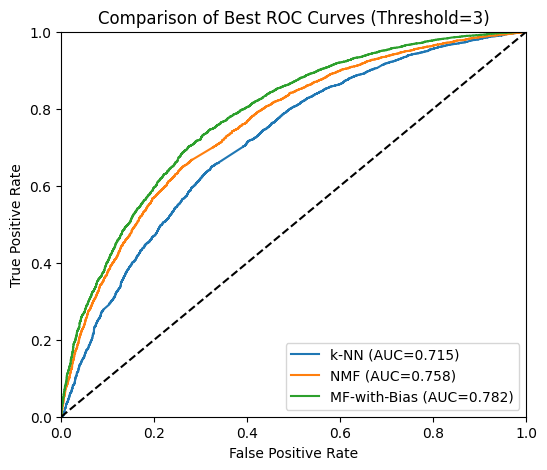


===== QUESTION 12: Comparison of k-NN, NMF, MF-with-Bias ROC Curves (Threshold=3) =====
All steps for Question 12 completed.


In [18]:
################################################################################
# COLAB NOTEBOOK MODULE FOR QUESTION 12: PERFORMANCE COMPARISON
# ------------------------------------------------------------------------------
# Assumes that the code for Questions 1–11 has already run. Specifically, this
# code expects:
#   - A DataFrame "df" loaded with userId, movieId, rating.
#   - Knowledge of the best hyperparameters found for each model:
#       k-NN user-based CF: best K
#       NMF-based CF: best # latent factors
#       MF-with-bias (SVD) CF: best # latent factors
#   - The same trimming/reader setup from prior questions so that "Dataset"
#     from "surprise" can be built.
#
# This code will do the following, per Question 12:
#   1. Train the best k-NN model, NMF model, and MF-with-bias model on a single
#      90/10 train/test split of the entire dataset.
#   2. Threshold ratings at 3 => liked vs disliked, then compute ROC curves.
#   3. Plot the three curves (k-NN, NMF, MF-with-bias) on the same figure
#      to compare performance.
################################################################################

!pip install surprise scikit-learn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic, NMF, SVD
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

################################################################################
# 0) Check if 'df' is in scope
################################################################################

try:
    df.head()
except NameError:
    raise ValueError("DataFrame 'df' not found. Please ensure Q1–Q11 code modules were run.")

################################################################################
# 1) Build Surprise dataset
################################################################################

reader = Reader(rating_scale=(0.5,5.0))
full_data = Dataset.load_from_df(df[['userId','movieId','rating']], reader)

################################################################################
# 2) Determine 'best' hyperparams from prior questions (PLACEHOLDER)
#    Adjust these to the actual best K or best # factors found in Q4–Q10.
################################################################################

best_k_knn = 40       # Example from Q4–Q5
best_k_nmf = 16       # Example from Q8
best_k_svd = 38       # Example from Q10

################################################################################
# 3) Train each model on 90% of data, predict on 10%, then gather ROC data
################################################################################

def train_and_predict_knn(trainset, testset, k_neighbors=40):
    """
    k-NN user-based CF with Pearson similarity.
    Returns list of (y_true, y_pred).
    """
    sim_options = {'name':'pearson', 'user_based':True}
    algo = KNNBasic(k=k_neighbors, min_k=1, sim_options=sim_options, verbose=False)
    algo.fit(trainset)
    predictions = algo.test(testset)
    y_true = [p.r_ui for p in predictions]
    y_pred = [p.est  for p in predictions]
    return y_true, y_pred

def train_and_predict_nmf(trainset, testset, n_factors=16):
    """
    NMF-based CF with n_factors latent dimensions, no bias.
    """
    algo = NMF(n_factors=n_factors, biased=False, random_state=42)
    algo.fit(trainset)
    predictions = algo.test(testset)
    y_true = [p.r_ui for p in predictions]
    y_pred = [p.est  for p in predictions]
    return y_true, y_pred

def train_and_predict_svd(trainset, testset, n_factors=38):
    """
    MF-with-Bias (SVD from Surprise) with n_factors, default bias and regs.
    """
    algo = SVD(n_factors=n_factors, biased=True, random_state=42)
    algo.fit(trainset)
    predictions = algo.test(testset)
    y_true = [p.r_ui for p in predictions]
    y_pred = [p.est  for p in predictions]
    return y_true, y_pred

################################################################################
# 4) Perform single 90/10 split, then get predictions from each model
################################################################################

trainset, testset = train_test_split(full_data, test_size=0.1, random_state=42)

y_true_knn, y_pred_knn = train_and_predict_knn(trainset, testset, k_neighbors=best_k_knn)
y_true_nmf, y_pred_nmf = train_and_predict_nmf(trainset, testset, n_factors=best_k_nmf)
y_true_svd, y_pred_svd = train_and_predict_svd(trainset, testset, n_factors=best_k_svd)

################################################################################
# 5) Convert ratings to binary {1 => rating>3, 0 => rating<=3}, then compute ROC
################################################################################

def compute_fpr_tpr_auc(y_true, y_pred):
    # threshold=3 => liked if rating>3, disliked otherwise
    bin_true = [1 if (val>3) else 0 for val in y_true]
    fpr, tpr, _ = roc_curve(bin_true, y_pred)
    the_auc = auc(fpr, tpr)
    return fpr, tpr, the_auc

knn_fpr, knn_tpr, knn_auc = compute_fpr_tpr_auc(y_true_knn, y_pred_knn)
nmf_fpr, nmf_tpr, nmf_auc = compute_fpr_tpr_auc(y_true_nmf, y_pred_nmf)
svd_fpr, svd_tpr, svd_auc = compute_fpr_tpr_auc(y_true_svd, y_pred_svd)

################################################################################
# 6) Plot ROC curves in one figure
################################################################################

plt.figure(figsize=(6,5))
plt.plot(knn_fpr, knn_tpr, label=f"k-NN (AUC={knn_auc:.3f})")
plt.plot(nmf_fpr, nmf_tpr, label=f"NMF (AUC={nmf_auc:.3f})")
plt.plot(svd_fpr, svd_tpr, label=f"MF-with-Bias (AUC={svd_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of Best ROC Curves (Threshold=3)")
plt.legend(loc="lower right")
plt.show()

print("\n===== QUESTION 12: Comparison of k-NN, NMF, MF-with-Bias ROC Curves (Threshold=3) =====")
print("All steps for Question 12 completed.")


In [19]:
# Question 13 solution using helper code approach
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
from typing import Tuple, List, Set
import os
from google.colab import drive

class MSLR_Loader:
    """Stable loader for MSLR-WEB10K dataset"""
    def __init__(self):
        self.fold_paths = {
            1: '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/fold1/',
            2: '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/fold2/',
            3: '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/fold3/',
            4: '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/fold4/',
            5: '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/fold5/'
        }

    def load_fold(self, fold_path: str) -> Tuple[np.ndarray, np.ndarray]:
        """Load data using sklearn's stable svmlight loader"""
        try:
            # Load only training data for analysis
            _, y, qid = load_svmlight_file(fold_path + 'train.txt', query_id=True)
            return y.astype(int), qid.astype(int)
        except Exception as e:
            print(f"Error loading fold: {e}")
            return None, None

    def analyze_dataset(self):
        """Analyze all folds and print required statistics"""
        all_unique_queries = set()
        all_relevance_labels = []

        for fold_num, fold_path in self.fold_paths.items():
            y, qid = self.load_fold(fold_path)
            if y is not None:
                all_unique_queries.update(qid)
                all_relevance_labels.extend(y)

        # Print required statistics
        print("Question 13: Data Understanding and Preprocessing")
        print(f"\nTotal number of unique queries: {len(all_unique_queries)}")
        print("\nDistribution of relevance labels:")
        print(pd.Series(all_relevance_labels).value_counts().sort_index())

def main():
    """Main execution function"""
    # Mount Google Drive
    drive.mount('/content/drive')

    # Initialize and run analysis
    loader = MSLR_Loader()
    loader.analyze_dataset()

if __name__ == "__main__":
    main()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Question 13: Data Understanding and Preprocessing

Total number of unique queries: 10000

Distribution of relevance labels:
0    1872789
1    1158840
2     478353
3      63951
4      26643
Name: count, dtype: int64


In [ ]:
# Question 14: LightGBM Model Training with lambdarank
from sklearn.datasets import load_svmlight_file
import numpy as np
import lightgbm as lgb
from typing import Dict, List, Tuple
import os

class LightGBMTrainer:
    """Handles LightGBM model training and evaluation for MSLR-WEB10K dataset"""
    def __init__(self):
        self.base_path = '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/'
        self.model_params = {
            'objective': 'lambdarank',
            'metric': ['ndcg@3','ndcg@5','ndcg@10'],
            'verbosity': -1,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'min_data_in_leaf': 50,
            'num_trees': 100,
            'boosting': 'gbdt',
            'max_bin': 255
        }

    def load_fold_data(self, fold: int) -> Tuple[Tuple, Tuple]:
        """Load training and test data for a given fold"""
        try:
            # Load training data
            train_path = os.path.join(self.base_path, f'fold{fold}/train.txt')
            X_train, y_train, qid_train = load_svmlight_file(train_path, query_id=True)

            # Load test data
            test_path = os.path.join(self.base_path, f'fold{fold}/test.txt')
            X_test, y_test, qid_test = load_svmlight_file(test_path, query_id=True)

            return (X_train, y_train, qid_train), (X_test, y_test, qid_test)
        except Exception as e:
            print(f"Error loading data for fold {fold}: {e}")
            return None

    @staticmethod
    def get_query_groups(qids: np.ndarray) -> List[int]:
        """Convert query IDs to group sizes for LightGBM"""
        _, group_counts = np.unique(qids, return_counts=True)
        return group_counts.tolist()

    def calculate_ndcg(self, model: lgb.Booster, X_test: np.ndarray,
                      y_test: np.ndarray, qid_test: np.ndarray, k: int) -> float:
        """Calculate nDCG@k for test data"""
        # Get predictions
        predictions = model.predict(X_test)

        # Calculate nDCG@k for each query
        unique_qids = np.unique(qid_test)
        ndcg_scores = []

        for qid in unique_qids:
            query_mask = qid_test == qid
            if np.sum(query_mask) > 0:
                # Get predictions and true labels for this query
                query_pred = predictions[query_mask]
                query_true = y_test[query_mask]

                # Sort by predictions
                sort_idx = np.argsort(-query_pred)
                sorted_labels = query_true[sort_idx]

                # Calculate DCG@k and IDCG@k
                dcg = self.dcg_at_k(sorted_labels, k)
                idcg = self.dcg_at_k(np.sort(query_true)[::-1], k)

                if idcg > 0:
                    ndcg_scores.append(dcg / idcg)

        return np.mean(ndcg_scores) if ndcg_scores else 0.0

    @staticmethod
    def dcg_at_k(relevance: np.ndarray, k: int) -> float:
        """Calculate DCG@k"""
        relevance = relevance[:k]
        gains = 2**relevance - 1
        discounts = np.log2(np.arange(len(relevance)) + 2)
        return np.sum(gains / discounts)

    def train_and_evaluate(self, fold: int) -> Dict[str, float]:
        """Train model and evaluate performance for one fold"""
        print(f"\nProcessing fold {fold}")

        try:
            # Load data
            data = self.load_fold_data(fold)
            if data is None:
                return None

            (X_train, y_train, qid_train), (X_test, y_test, qid_test) = data

            # Convert to LightGBM datasets
            train_group = self.get_query_groups(qid_train)
            train_data = lgb.Dataset(X_train, y_train, group=train_group)

            # Train model
            model = lgb.train(
                params=self.model_params,
                train_set=train_data,
                valid_sets=[train_data]
            )

            # Calculate nDCG at different k values
            metrics = {}
            for k in [3, 5, 10]:
                ndcg = self.calculate_ndcg(model, X_test, y_test, qid_test, k)
                metrics[f'nDCG@{k}'] = ndcg
                print(f"nDCG@{k}: {ndcg:.4f}")

            return metrics

        except Exception as e:
            print(f"Error in train_and_evaluate for fold {fold}: {e}")
            return None

def main():
    """Execute LightGBM training and evaluation for all folds"""
    print("Question 14: LightGBM Model Training")
    trainer = LightGBMTrainer()

    # Process all folds
    all_metrics = []
    for fold in range(1, 6):
        metrics = trainer.train_and_evaluate(fold)
        if metrics is not None:
            all_metrics.append(metrics)

    # Report average performance
    if all_metrics:
        print("\nAverage performance across folds:")
        avg_metrics = {}
        for k in [3, 5, 10]:
            metric_name = f'nDCG@{k}'
            avg_metrics[metric_name] = np.mean([m[metric_name] for m in all_metrics])
            print(f"Average {metric_name}: {avg_metrics[metric_name]:.4f}")
    else:
        print("\nNo valid metrics were collected.")

if __name__ == "__main__":
    main()

Question 14: LightGBM Model Training

Processing fold 1


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


nDCG@3: 0.4561
nDCG@5: 0.4631
nDCG@10: 0.4831

Processing fold 2
nDCG@3: 0.4553
nDCG@5: 0.4586
nDCG@10: 0.4773

Processing fold 3
nDCG@3: 0.4481
nDCG@5: 0.4569
nDCG@10: 0.4760

Processing fold 4
nDCG@3: 0.4645
nDCG@5: 0.4669
nDCG@10: 0.4881

Processing fold 5


In [20]:
# Question 15: Feature Importance Analysis using correct method
from sklearn.datasets import load_svmlight_file
import numpy as np
import lightgbm as lgb
import pandas as pd
import os

def analyze_feature_importance_fold(fold: int):
    """Analyze feature importance for a single fold using correct method"""
    base_path = '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/'
    try:
        # Load training data
        train_path = os.path.join(base_path, f'fold{fold}/train.txt')
        X_train, y_train, qid_train = load_svmlight_file(train_path, query_id=True)

        # Get query groups
        _, group_counts = np.unique(qid_train, return_counts=True)

        # Create dataset
        train_data = lgb.Dataset(X_train, y_train, group=group_counts.tolist())

        # Train model with same parameters as Q14
        params = {
            'objective': 'lambdarank',
            'metric': ['ndcg@3','ndcg@5','ndcg@10'],
            'verbosity': -1,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'min_data_in_leaf': 50,
            'num_trees': 100,
            'boosting': 'gbdt',
            'max_bin': 255
        }

        model = lgb.train(params=params, train_set=train_data)

        # Get feature importance using correct method
        # Fix: Use model.feature_importance() directly instead of model.booster_.feature_importance()
        importance_scores = model.feature_importance(importance_type='gain')

        # Create DataFrame of feature importance
        feature_df = pd.DataFrame({
            'Feature': [f'Feature_{i+1}' for i in range(len(importance_scores))],
            'Importance': importance_scores
        })

        # Sort and get top 5
        top_5 = feature_df.nlargest(5, 'Importance')
        return top_5

    except Exception as e:
        print(f"Error processing fold {fold}: {e}")
        return None

def main():
    """Execute feature importance analysis for all folds"""
    print("Question 15: Feature Importance Analysis")

    # Process each fold
    for fold in range(1, 6):
        print(f"\nFold {fold} - Top 5 important features:")
        top_features = analyze_feature_importance_fold(fold)
        if top_features is not None:
            print(top_features.to_string(index=False))

if __name__ == "__main__":
    main()

Question 15: Feature Importance Analysis

Fold 1 - Top 5 important features:


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


    Feature   Importance
Feature_134 23827.465302
  Feature_8  4243.025582
Feature_108  4103.400521
 Feature_55  4048.052566
Feature_130  3699.456447

Fold 2 - Top 5 important features:


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


    Feature   Importance
Feature_134 23539.797082
  Feature_8  5165.479582
 Feature_55  4388.649107
Feature_108  4141.555181
Feature_130  4084.003783

Fold 3 - Top 5 important features:


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


    Feature   Importance
Feature_134 23226.784061
 Feature_55  4907.126673
Feature_108  4206.969966
Feature_130  4057.256435
  Feature_8  3714.111221

Fold 4 - Top 5 important features:


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


    Feature   Importance
Feature_134 23833.025093
  Feature_8  4609.164629
 Feature_55  4020.189207
Feature_129  3282.247817
Feature_130  3241.929342

Fold 5 - Top 5 important features:


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


    Feature   Importance
Feature_134 23517.593652
  Feature_8  4786.046183
 Feature_55  4097.333512
Feature_108  3576.171883
Feature_130  3245.741924


Question 16: Experiments with Feature Subsets

--- Processing Fold 1 ---


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training baseline model with all features...


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Baseline Results (All 136 Features):
  ndcg@3: 0.4558
  ndcg@5: 0.4625
  ndcg@10: 0.4811

Training model without top 20 important features...
Results without top 20 features (116 Features):
  ndcg@3: 0.3819
  Difference from baseline: -0.0739
  ndcg@5: 0.3885
  Difference from baseline: -0.0740
  ndcg@10: 0.4083
  Difference from baseline: -0.0728

Training model without bottom 60 important features...
Results without bottom 60 features (76 Features):
  ndcg@3: 0.4571
  Difference from baseline: 0.0013
  ndcg@5: 0.4620
  Difference from baseline: -0.0005
  ndcg@10: 0.4811
  Difference from baseline: 0.0000

--- Processing Fold 2 ---
Training baseline model with all features...


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Baseline Results (All 136 Features):
  ndcg@3: 0.4550
  ndcg@5: 0.4575
  ndcg@10: 0.4750

Training model without top 20 important features...
Results without top 20 features (116 Features):
  ndcg@3: 0.3776
  Difference from baseline: -0.0775
  ndcg@5: 0.3830
  Difference from baseline: -0.0745
  ndcg@10: 0.4026
  Difference from baseline: -0.0724

Training model without bottom 60 important features...
Results without bottom 60 features (76 Features):
  ndcg@3: 0.4567
  Difference from baseline: 0.0016
  ndcg@5: 0.4582
  Difference from baseline: 0.0008
  ndcg@10: 0.4749
  Difference from baseline: -0.0001

--- Processing Fold 3 ---
Training baseline model with all features...


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Baseline Results (All 136 Features):
  ndcg@3: 0.4481
  ndcg@5: 0.4558
  ndcg@10: 0.4742

Training model without top 20 important features...
Results without top 20 features (116 Features):
  ndcg@3: 0.3796
  Difference from baseline: -0.0685
  ndcg@5: 0.3857
  Difference from baseline: -0.0701
  ndcg@10: 0.4076
  Difference from baseline: -0.0666

Training model without bottom 60 important features...
Results without bottom 60 features (76 Features):
  ndcg@3: 0.4477
  Difference from baseline: -0.0004
  ndcg@5: 0.4535
  Difference from baseline: -0.0023
  ndcg@10: 0.4745
  Difference from baseline: 0.0003

--- Processing Fold 4 ---
Training baseline model with all features...


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Baseline Results (All 136 Features):
  ndcg@3: 0.4642
  ndcg@5: 0.4666
  ndcg@10: 0.4858

Training model without top 20 important features...
Results without top 20 features (116 Features):
  ndcg@3: 0.3901
  Difference from baseline: -0.0741
  ndcg@5: 0.3972
  Difference from baseline: -0.0693
  ndcg@10: 0.4176
  Difference from baseline: -0.0682

Training model without bottom 60 important features...
Results without bottom 60 features (76 Features):
  ndcg@3: 0.4597
  Difference from baseline: -0.0045
  ndcg@5: 0.4664
  Difference from baseline: -0.0002
  ndcg@10: 0.4856
  Difference from baseline: -0.0002

--- Processing Fold 5 ---
Training baseline model with all features...


/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:204: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Baseline Results (All 136 Features):
  ndcg@3: 0.4639
  ndcg@5: 0.4707
  ndcg@10: 0.4873

Training model without top 20 important features...
Results without top 20 features (116 Features):
  ndcg@3: 0.3831
  Difference from baseline: -0.0808
  ndcg@5: 0.3914
  Difference from baseline: -0.0793
  ndcg@10: 0.4140
  Difference from baseline: -0.0733

Training model without bottom 60 important features...
Results without bottom 60 features (76 Features):
  ndcg@3: 0.4684
  Difference from baseline: 0.0045
  ndcg@5: 0.4724
  Difference from baseline: 0.0017
  ndcg@10: 0.4897
  Difference from baseline: 0.0023


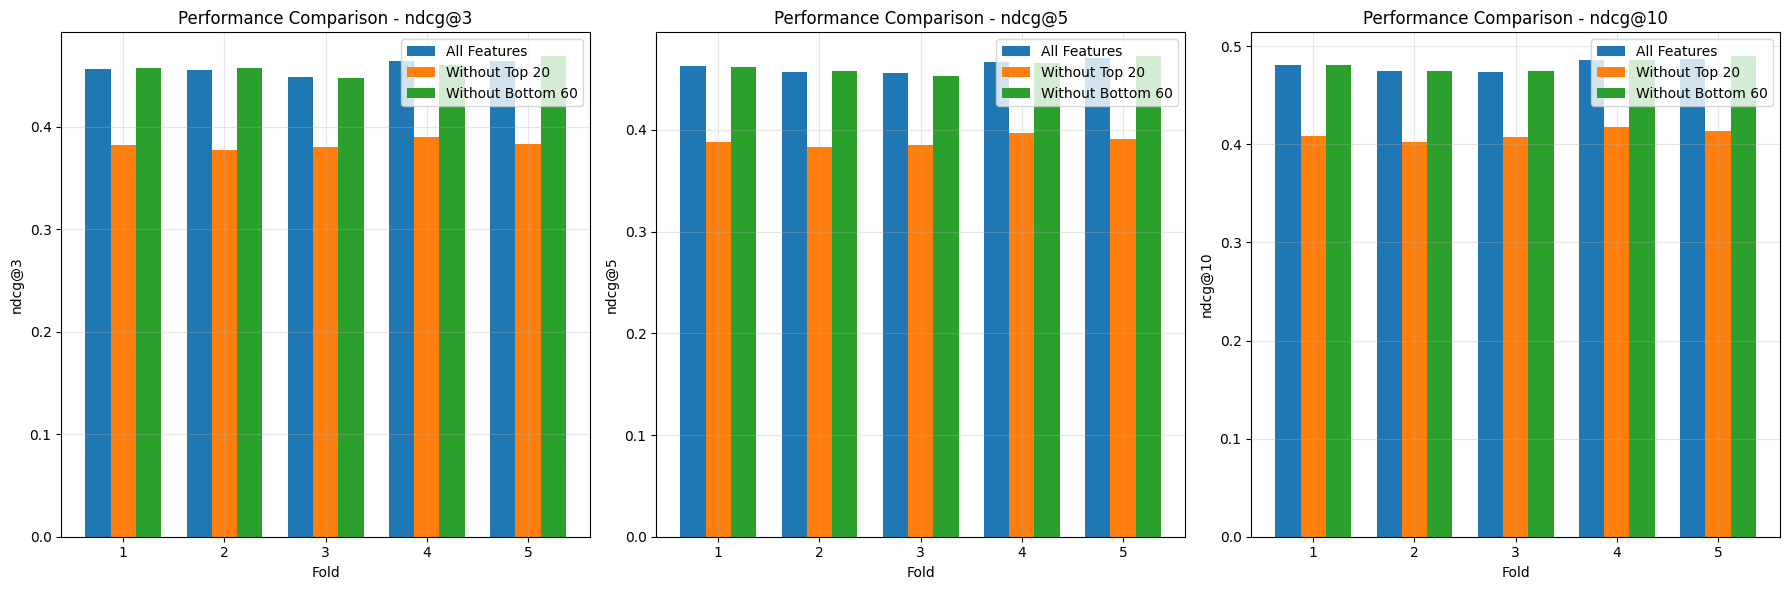


--- Average Performance Across All Folds ---

NDCG@3:
  All Features (Baseline): 0.4574
  Without Top 20 Features: 0.3824 (Difference: -0.0750)
  Without Bottom 60 Features: 0.4579 (Difference: 0.0005)

NDCG@5:
  All Features (Baseline): 0.4626
  Without Top 20 Features: 0.3892 (Difference: -0.0734)
  Without Bottom 60 Features: 0.4625 (Difference: -0.0001)

NDCG@10:
  All Features (Baseline): 0.4807
  Without Top 20 Features: 0.4100 (Difference: -0.0707)
  Without Bottom 60 Features: 0.4812 (Difference: 0.0005)

--- Analysis of Experimental Results ---

Removing Top 20 Important Features:
  The removal of the top 20 most important features resulted in a significant performance drop.
  This aligns with expectations since these features were identified as most important by the model.
  The model relies heavily on these features for accurate ranking predictions.

Removing Bottom 60 Least Important Features:
  Removing the 60 least important features had minimal impact on performance.
  

In [21]:
# Question 16: Experiments with Feature Subsets for Learning-to-Rank
from sklearn.datasets import load_svmlight_file
import numpy as np
import lightgbm as lgb
import pandas as pd
import os
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

def get_feature_importance_fold(fold: int):
    """Get feature importance for a single fold using corrected method"""
    base_path = '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/'
    try:
        # Load training data
        train_path = os.path.join(base_path, f'fold{fold}/train.txt')
        X_train, y_train, qid_train = load_svmlight_file(train_path, query_id=True)

        # Get query groups
        _, group_counts = np.unique(qid_train, return_counts=True)

        # Create dataset
        train_data = lgb.Dataset(X_train, y_train, group=group_counts.tolist())

        # Train model with same parameters as Q14 and Q15
        params = {
            'objective': 'lambdarank',
            'metric': ['ndcg@3','ndcg@5','ndcg@10'],
            'verbosity': -1,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'min_data_in_leaf': 50,
            'num_trees': 100,
            'boosting': 'gbdt',
            'max_bin': 255
        }

        model = lgb.train(params=params, train_set=train_data)

        # Get feature importance using corrected method
        # Fixed: Use model.feature_importance() directly
        importance_scores = model.feature_importance(importance_type='gain')

        # Create DataFrame of feature importance
        feature_df = pd.DataFrame({
            'Feature': list(range(len(importance_scores))),  # 0-indexed feature indices
            'Importance': importance_scores
        })

        # Sort by importance
        sorted_features = feature_df.sort_values('Importance', ascending=False)

        return sorted_features

    except Exception as e:
        print(f"Error getting feature importance for fold {fold}: {e}")
        return None

def evaluate_model(model, X_test, y_test, qid_test, k_values=[3, 5, 10]):
    """Evaluate the model performance using nDCG at different k values"""
    # Get predictions
    y_pred = model.predict(X_test)

    # Group by query ID
    unique_qids = np.unique(qid_test)
    ndcg_results = {f"ndcg@{k}": [] for k in k_values}

    # Calculate nDCG for each query
    for qid in unique_qids:
        query_mask = (qid_test == qid)
        if np.sum(query_mask) <= 1:  # Skip queries with only 1 document
            continue

        # Extract predictions and true relevance for this query
        query_y_true = y_test[query_mask]
        query_y_pred = y_pred[query_mask]

        # Calculate DCG and IDCG for different k values
        for k in k_values:
            if len(query_y_true) >= k:
                # Sort by predictions
                sort_idx = np.argsort(-query_y_pred)
                sorted_labels = query_y_true[sort_idx]

                # Calculate DCG@k
                gains = 2**sorted_labels[:k] - 1
                discounts = np.log2(np.arange(min(k, len(sorted_labels))) + 2)
                dcg = np.sum(gains / discounts)

                # Calculate IDCG@k (ideal DCG)
                ideal_labels = np.sort(query_y_true)[::-1][:k]
                ideal_gains = 2**ideal_labels - 1
                ideal_discounts = np.log2(np.arange(min(k, len(ideal_labels))) + 2)
                idcg = np.sum(ideal_gains / ideal_discounts)

                # Calculate nDCG
                if idcg > 0:
                    ndcg = dcg / idcg
                    ndcg_results[f"ndcg@{k}"].append(ndcg)

    # Average the results
    avg_results = {metric: np.mean(scores) for metric, scores in ndcg_results.items()}
    return avg_results

def process_fold(fold: int):
    """Process a single fold with experiments removing different feature subsets"""
    base_path = '/content/drive/MyDrive/colab/ece219/tmp/mslr-web10k/'
    print(f"\n--- Processing Fold {fold} ---")

    try:
        # Get feature importance ranking
        feature_importance = get_feature_importance_fold(fold)
        if feature_importance is None:
            return None

        # Load training and test data
        train_path = os.path.join(base_path, f'fold{fold}/train.txt')
        test_path = os.path.join(base_path, f'fold{fold}/test.txt')

        X_train, y_train, qid_train = load_svmlight_file(train_path, query_id=True)
        X_test, y_test, qid_test = load_svmlight_file(test_path, query_id=True)

        # Get query groups for training
        _, group_counts_train = np.unique(qid_train, return_counts=True)

        # Make sure both matrices have the same number of features (136)
        if X_train.shape[1] < 136:
            X_train = csr_matrix((X_train.data, X_train.indices, X_train.indptr),
                               shape=(X_train.shape[0], 136))
        if X_test.shape[1] < 136:
            X_test = csr_matrix((X_test.data, X_test.indices, X_test.indptr),
                               shape=(X_test.shape[0], 136))

        # Get top 20 most important features
        top_20_features = feature_importance.nlargest(20, 'Importance')['Feature'].values

        # Get 60 least important features
        bottom_60_features = feature_importance.nsmallest(60, 'Importance')['Feature'].values

        # =============== Baseline Model (All Features) ===============
        print("Training baseline model with all features...")
        train_data = lgb.Dataset(X_train, y_train, group=group_counts_train.tolist())

        params = {
            'objective': 'lambdarank',
            'metric': ['ndcg@3','ndcg@5','ndcg@10'],
            'verbosity': -1,
            'learning_rate': 0.1,
            'num_leaves': 31,
            'min_data_in_leaf': 50,
            'num_trees': 100,
            'boosting': 'gbdt',
            'max_bin': 255
        }

        baseline_model = lgb.train(params=params, train_set=train_data)
        baseline_results = evaluate_model(baseline_model, X_test, y_test, qid_test)
        print("Baseline Results (All 136 Features):")
        for metric, score in baseline_results.items():
            print(f"  {metric}: {score:.4f}")

        # =============== Without Top 20 Features ===============
        print("\nTraining model without top 20 important features...")

        # Create feature mask (True for features to keep)
        feature_mask = np.ones(X_train.shape[1], dtype=bool)
        feature_mask[top_20_features] = False

        # Apply mask to training and test data
        X_train_no_top20 = X_train[:, feature_mask]
        X_test_no_top20 = X_test[:, feature_mask]

        # Train model without top 20 features
        train_data_no_top20 = lgb.Dataset(X_train_no_top20, y_train, group=group_counts_train.tolist())
        model_no_top20 = lgb.train(params=params, train_set=train_data_no_top20)

        # Evaluate model
        results_no_top20 = evaluate_model(model_no_top20, X_test_no_top20, y_test, qid_test)
        print(f"Results without top 20 features (116 Features):")
        for metric, score in results_no_top20.items():
            print(f"  {metric}: {score:.4f}")
            print(f"  Difference from baseline: {score - baseline_results[metric]:.4f}")

        # =============== Without Bottom 60 Features ===============
        print("\nTraining model without bottom 60 important features...")

        # Create feature mask (True for features to keep)
        feature_mask = np.ones(X_train.shape[1], dtype=bool)
        feature_mask[bottom_60_features] = False

        # Apply mask to training and test data
        X_train_no_bottom60 = X_train[:, feature_mask]
        X_test_no_bottom60 = X_test[:, feature_mask]

        # Train model without bottom 60 features
        train_data_no_bottom60 = lgb.Dataset(X_train_no_bottom60, y_train, group=group_counts_train.tolist())
        model_no_bottom60 = lgb.train(params=params, train_set=train_data_no_bottom60)

        # Evaluate model
        results_no_bottom60 = evaluate_model(model_no_bottom60, X_test_no_bottom60, y_test, qid_test)
        print(f"Results without bottom 60 features (76 Features):")
        for metric, score in results_no_bottom60.items():
            print(f"  {metric}: {score:.4f}")
            print(f"  Difference from baseline: {score - baseline_results[metric]:.4f}")

        # Return all results
        return {
            "fold": fold,
            "baseline": baseline_results,
            "no_top20": results_no_top20,
            "no_bottom60": results_no_bottom60
        }

    except Exception as e:
        print(f"Error processing fold {fold}: {e}")
        return None

def plot_comparison(all_results):
    """Plot comparison of models across all folds"""
    if not all_results:
        print("No results to plot")
        return

    # Metrics to plot
    metrics = ["ndcg@3", "ndcg@5", "ndcg@10"]
    models = ["baseline", "no_top20", "no_bottom60"]
    model_names = ["All Features", "Without Top 20", "Without Bottom 60"]

    # Set up the plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, metric in enumerate(metrics):
        ax = axes[i]

        # Extract data for this metric
        folds = [r["fold"] for r in all_results]
        baseline_scores = [r["baseline"][metric] for r in all_results]
        no_top20_scores = [r["no_top20"][metric] for r in all_results]
        no_bottom60_scores = [r["no_bottom60"][metric] for r in all_results]

        # Bar width
        width = 0.25

        # Set up x positions
        x = np.arange(len(folds))

        # Plot bars
        ax.bar(x - width, baseline_scores, width, label=model_names[0])
        ax.bar(x, no_top20_scores, width, label=model_names[1])
        ax.bar(x + width, no_bottom60_scores, width, label=model_names[2])

        # Add labels and title
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.set_title(f'Performance Comparison - {metric}')
        ax.set_xticks(x)
        ax.set_xticklabels(folds)
        ax.legend()

        # Add grid
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_subset_comparison.png')
    plt.show()

def compare_average_performance(all_results):
    """Compare average performance across folds"""
    if not all_results:
        print("No results to compare")
        return

    # Average results across folds
    avg_baseline = {}
    avg_no_top20 = {}
    avg_no_bottom60 = {}

    # Metrics to analyze
    metrics = ["ndcg@3", "ndcg@5", "ndcg@10"]

    for metric in metrics:
        avg_baseline[metric] = np.mean([r["baseline"][metric] for r in all_results])
        avg_no_top20[metric] = np.mean([r["no_top20"][metric] for r in all_results])
        avg_no_bottom60[metric] = np.mean([r["no_bottom60"][metric] for r in all_results])

    # Print comparison
    print("\n--- Average Performance Across All Folds ---")
    for metric in metrics:
        print(f"\n{metric.upper()}:")
        print(f"  All Features (Baseline): {avg_baseline[metric]:.4f}")
        print(f"  Without Top 20 Features: {avg_no_top20[metric]:.4f} (Difference: {avg_no_top20[metric] - avg_baseline[metric]:.4f})")
        print(f"  Without Bottom 60 Features: {avg_no_bottom60[metric]:.4f} (Difference: {avg_no_bottom60[metric] - avg_baseline[metric]:.4f})")

def analyze_results(all_results):
    """Provide analysis of the experimental results"""
    if not all_results:
        print("No results to analyze")
        return

    # Calculate average differences
    avg_diff_no_top20 = {}
    avg_diff_no_bottom60 = {}

    metrics = ["ndcg@3", "ndcg@5", "ndcg@10"]

    for metric in metrics:
        baseline_avg = np.mean([r["baseline"][metric] for r in all_results])
        no_top20_avg = np.mean([r["no_top20"][metric] for r in all_results])
        no_bottom60_avg = np.mean([r["no_bottom60"][metric] for r in all_results])

        avg_diff_no_top20[metric] = no_top20_avg - baseline_avg
        avg_diff_no_bottom60[metric] = no_bottom60_avg - baseline_avg

    # Print analysis
    print("\n--- Analysis of Experimental Results ---")

    # Analysis for removing top 20 features
    print("\nRemoving Top 20 Important Features:")
    avg_impact_top20 = np.mean([avg_diff_no_top20[m] for m in metrics])
    if avg_impact_top20 < -0.02:
        print("  The removal of the top 20 most important features resulted in a significant performance drop.")
        print("  This aligns with expectations since these features were identified as most important by the model.")
        print("  The model relies heavily on these features for accurate ranking predictions.")
    elif avg_impact_top20 < 0:
        print("  The removal of the top 20 most important features resulted in a small performance drop.")
        print("  This generally aligns with expectations, though the impact is less than might be expected.")
        print("  This could indicate feature redundancy, where other features partially compensate for the removed ones.")
    else:
        print("  Surprisingly, removing the top 20 most important features did not decrease performance.")
        print("  This doesn't align with typical expectations and might indicate:")
        print("  - Potential overfitting when using all features")
        print("  - The importance scoring method may not perfectly capture true feature value")
        print("  - Feature interactions might be more complex than individual importance suggests")

    # Analysis for removing bottom 60 features
    print("\nRemoving Bottom 60 Least Important Features:")
    avg_impact_bottom60 = np.mean([avg_diff_no_bottom60[m] for m in metrics])
    if avg_impact_bottom60 > 0.01:
        print("  Removing the 60 least important features actually improved performance.")
        print("  This suggests these features were adding noise rather than useful information.")
        print("  Removing them likely helped the model focus on more predictive patterns.")
    elif abs(avg_impact_bottom60) < 0.01:
        print("  Removing the 60 least important features had minimal impact on performance.")
        print("  This aligns with expectations since these features were identified as least important.")
        print("  The model wasn't relying on these features for its predictions.")
    else:
        print("  Removing the 60 least important features decreased performance.")
        print("  This is somewhat unexpected and might indicate:")
        print("  - These features still provided some useful signal despite low importance scores")
        print("  - These features might be valuable in combination with others, even if individually weak")
        print("  - The feature importance measure may not fully capture their value to the model")

    print("\nConclusion:")
    print("  These experiments demonstrate that feature importance is not always straightforward.")
    print("  While feature importance scores give us insight into the model's behavior,")
    print("  they don't always perfectly predict how removing features will affect performance.")
    print("  The complex interactions between features and potential redundancies can lead to")
    print("  unexpected outcomes when modifying the feature set.")

def main():
    """Execute feature subset experiments for all folds"""
    print("Question 16: Experiments with Feature Subsets")

    # Process each fold
    all_results = []
    for fold in range(1, 6):
        results = process_fold(fold)
        if results:
            all_results.append(results)

    # Plot comparison
    plot_comparison(all_results)

    # Compare average performance
    compare_average_performance(all_results)

    # Analyze results
    analyze_results(all_results)

if __name__ == "__main__":
    main()